# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


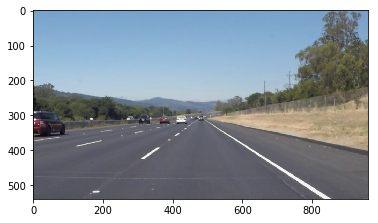

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [14]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def split(arr, cond):
    return [arr[cond], arr[~cond]]

def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lines = np.empty(shape=[0, 4], dtype=np.int32)
    right_lines = np.empty(shape=[0, 4], dtype=np.int32)
    
    #left_line_avg = np.average(left_lines)
    #right_line_avg = np.average(right_lines)    
     
    for line in lines:
        for x1,y1,x2,y2 in line:
            # slope > 0 -> right line detected
            if ((y2-y1)/(x2-x1)) > 0:
                right_lines = np.append(right_lines, [[x1,y1,x2,y2]], axis=0)
            # slope <= 0 -> left line detected
            else:
                left_lines = np.append(left_lines, [[x1,y1,x2,y2]], axis=0)
     
    right_line_avg = right_lines.mean(axis=0, dtype=np.int32)
    left_line_avg = left_lines.mean(axis=0, dtype=np.int32)
    
    print('right_line_avg:', right_line_avg) 
    print('left_line_avg:', left_line_avg) 
    
    # TODO: Add interpolation here
    
    #print(left_line_avg[0],left_line_avg[1],left_line_avg[2], left_line_avg[3])   
    #for line in right_lines:
    #for x1,y1,x2,y2 in left_line_avg:
    cv2.line(img, (left_line_avg[0],left_line_avg[1]),(left_line_avg[2], left_line_avg[3]), color, thickness)
    cv2.line(img, (right_line_avg[0],right_line_avg[1]),(right_line_avg[2], right_line_avg[3]), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [15]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def detect_line_segments_dbg(img, image_name):
    gray_image = grayscale(img)
    mpimg.imsave('test_images_output/intermediate_stages/'+image_name+'_gray_image', gray_image, format="jpg", cmap='gray')
    
    blur_image = gaussian_blur(gray_image, 7)
    mpimg.imsave('test_images_output/intermediate_stages/'+image_name+'_blur_image', blur_image, format="jpg", cmap='gray')
    
    canny_image = canny(blur_image, 100, 150)
    mpimg.imsave('test_images_output/intermediate_stages/'+image_name+'_canny_image', canny_image, format="jpg", cmap='gray')
    
    hough_image = hough_lines(canny_image, 1, np.pi/180, 1, 5, 1)
    mpimg.imsave('test_images_output/intermediate_stages/'+image_name+'_hough_image', hough_image, format="jpg", cmap='gray')
    
    roi_pts = np.array([[(380,330),(0, 540), (960, 540), (580,330)]], dtype=np.int32)  
    masked_image = region_of_interest(hough_image, np.int32(roi_pts)) 
    mpimg.imsave('test_images_output/intermediate_stages/'+image_name+'_masked_image', masked_image, format="jpg")
    
    segment_image = weighted_img(masked_image, img, α=0.8, β=1., γ=0.)
    
    return segment_image

def detect_line_segments(img):
    gray_image = grayscale(img)
    
    blur_image = gaussian_blur(gray_image, 7)
    
    canny_image = canny(blur_image, 100, 150)
    
    hough_image = hough_lines(canny_image, 1, np.pi/180, 1, 5, 1)
    
    roi_pts = np.array([[(380,330),(0, 540), (960, 540), (580,330)]], dtype=np.int32)  
    masked_image = region_of_interest(hough_image, np.int32(roi_pts)) 
    
    segment_image = weighted_img(masked_image, img, α=0.8, β=1., γ=0.)
    
    return segment_image

test_images = os.listdir("test_images/")
for test_image_name in test_images:
    print ('test_images/'+test_image_name)
    image = mpimg.imread('test_images/'+test_image_name)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    
    # Todo: Add pipeline here
    line_segment_image = detect_line_segments_dbg(image, test_image_name)
    
    mpimg.imsave('test_images_output/'+test_image_name, line_segment_image, format="jpg")
    #plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    
    



test_images/solidYellowCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
right_line_avg: [547 315 556 318]
left_line_avg: [444 352 454 346]
test_images/solidWhiteRight.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
right_line_avg: [636 403 645 407]
left_line_avg: [302 327 311 325]
test_images/solidYellowCurve2.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
right_line_avg: [694 394 707 399]
left_line_avg: [444 327 453 321]
test_images/whiteCarLaneSwitch.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
right_line_avg: [636 370 646 373]
left_line_avg: [515 343 522 339]
test_images/solidWhiteCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
right_line_avg: [588 371 603 378]
left_line_avg: [410 316 419 315]
test_images/solidYellowLeft.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
right_line_avg: [650 380 662 385]
left_line_avg

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = detect_line_segments(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

right_line_avg: [649 345 662 350]
left_line_avg: [538 236 548 233]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  1%|          | 2/222 [00:00<00:15, 13.79it/s]

right_line_avg: [649 345 662 350]
left_line_avg: [538 236 548 233]
right_line_avg: [649 370 660 375]
left_line_avg: [501 279 509 276]
right_line_avg: [654 370 664 374]
left_line_avg: [515 289 522 287]


  2%|▏         | 5/222 [00:00<00:18, 11.47it/s]

right_line_avg: [656 357 668 362]
left_line_avg: [480 315 487 312]
right_line_avg: [636 371 650 378]
left_line_avg: [483 299 490 297]
right_line_avg: 

  3%|▎         | 7/222 [00:00<00:18, 11.80it/s]

[643 377 655 382]
left_line_avg: [497 311 505 309]
right_line_avg: [632 376 643 381]
left_line_avg: [419 310 426 307]
right_line_avg: [594 362 608 369]
left_line_avg: [479 312 486 310]
right_line_avg: [592 378 603 383]
left_line_avg: [377 321 384 319]


  5%|▍         | 11/222 [00:00<00:15, 13.58it/s]

right_line_avg: [583 374 599 382]
left_line_avg: [343 305 351 302]
right_line_avg: [606 393 617 398]
left_line_avg: [375 303 382 299]
right_line_avg: [633 395 643 400]
left_line_avg: [356 332 364 329]


  7%|▋         | 15/222 [00:01<00:15, 13.20it/s]

right_line_avg: [615 388 625 393]
left_line_avg: [297 329 307 325]
right_line_avg: [601 382 611 386]
left_line_avg: [284 363 292 359]
right_line_avg: [558 359 574 366]
left_line_avg: [315 336 322 333]


  9%|▊         | 19/222 [00:01<00:13, 14.58it/s]

right_line_avg: [597 379 609 385]
left_line_avg: [322 333 329 330]
right_line_avg: [579 364 594 371]
left_line_avg: [313 321 321 318]
right_line_avg: [658 406 672 413]
left_line_avg: [322 298 330 296]
right_line_avg: [563 354 580 362]
left_line_avg: [348 311 355 308]


  9%|▉         | 21/222 [00:01<00:13, 15.34it/s]

right_line_avg: [590 388 601 393]
left_line_avg: [317 317 324 315]
right_line_avg: [556 359 575 368]
left_line_avg: [325 316 333 314]
right_line_avg: [593 373 610 381]
left_line_avg: [352 301 360 298]
right_line_avg: [580 366 598 374]
left_line_avg: [352 317 361 314]
right_line_avg: [618 392 629 397]
left_line_avg: [330 333 339 330]


 13%|█▎        | 28/222 [00:01<00:11, 17.16it/s]

right_line_avg: [587 373 598 378]
left_line_avg: [313 328 323 325]
right_line_avg: [624 390 637 397]
left_line_avg: [329 340 338 336]
right_line_avg: [636 377 651 384]
left_line_avg: [302 337 310 334]
right_line_avg: [617 386 634 393]
left_line_avg: [336 313 344 311]


 14%|█▍        | 32/222 [00:02<00:10, 17.80it/s]

right_line_avg: [555 359 570 365]
left_line_avg: [299 327 306 325]
right_line_avg: [599 381 621 392]
left_line_avg: [306 312 314 310]
right_line_avg: [594 373 607 379]
left_line_avg: [321 307 329 305]
right_line_avg: [569 358 587 367]
left_line_avg: [337 315 344 313]


 16%|█▌        | 36/222 [00:02<00:10, 18.35it/s]

right_line_avg: [602 383 615 389]
left_line_avg: [312 324 321 322]
right_line_avg: [555 365 571 373]
left_line_avg: [324 333 332 331]
right_line_avg: [568 342 591 353]
left_line_avg: [331 329 340 327]
right_line_avg: [555 362 572 370]
left_line_avg: [322 334 331 331]


 18%|█▊        | 40/222 [00:02<00:09, 18.25it/s]

right_line_avg: [620 392 633 399]
left_line_avg: [301 353 309 350]
right_line_avg: [578 370 589 375]
left_line_avg: [281 372 291 368]
right_line_avg: [582 379 594 384]
left_line_avg: [304 358 313 356]
right_line_avg: [589 388 603 395]
left_line_avg: [285 330 293 327]


 19%|█▉        | 43/222 [00:02<00:09, 18.42it/s]

right_line_avg: [576 375 594 384]
left_line_avg: [335 314 342 312]
right_line_avg: [593 381 607 388]
left_line_avg: [306 311 314 309]
right_line_avg: [597 379 609 385]
left_line_avg: [327 321 335 319]
right_line_avg: [624 390 637 396]
left_line_avg: [310 330 319 328]


 20%|██        | 45/222 [00:02<00:10, 16.59it/s]

right_line_avg: [573 381 598 393]
left_line_avg: [312 315 321 313]
right_line_avg: [637 397 650 404]
left_line_avg: [317 317 325 315]
right_line_avg: [602 379 614 385]
left_line_avg: [308 336 316 334]


 22%|██▏       | 49/222 [00:03<00:15, 11.22it/s]

right_line_avg: [553 365 567 371]
left_line_avg: [356 344 364 342]
right_line_avg: [610 390 620 394]
left_line_avg: [298 356 307 353]
right_line_avg: [558 356 583 369]
left_line_avg: [306 357 315 354]
right_line_avg: [615 381 627 387]
left_line_avg: [330 352 338 349]


 24%|██▍       | 53/222 [00:03<00:14, 11.52it/s]

right_line_avg: [614 383 626 389]
left_line_avg: [330 342 339 339]
right_line_avg: [594 380 606 386]
left_line_avg: [342 317 348 315]
right_line_avg: [567 354 585 364]
left_line_avg: [373 306 381 304]


 26%|██▌       | 57/222 [00:04<00:13, 11.79it/s]

right_line_avg: [645 403 657 408]
left_line_avg: [364 305 372 303]
right_line_avg: [601 371 615 377]
left_line_avg: [320 322 327 320]
right_line_avg: [620 385 636 393]
left_line_avg: [316 313 324 311]


 27%|██▋       | 59/222 [00:04<00:12, 12.60it/s]

right_line_avg: [604 389 617 395]
left_line_avg: [317 314 326 312]
right_line_avg: [590 363 607 371]
left_line_avg: [288 322 297 320]
right_line_avg: [608 389 622 397]
left_line_avg: [318 321 327 319]


 27%|██▋       | 61/222 [00:04<00:13, 11.86it/s]

right_line_avg: [564 357 579 365]
left_line_avg: [299 351 306 348]
right_line_avg: [606 390 618 395]
left_line_avg: [311 341 318 339]


 29%|██▉       | 65/222 [00:04<00:13, 11.73it/s]

right_line_avg: [590 355 609 365]
left_line_avg: [346 330 355 327]
right_line_avg: [598 384 609 389]
left_line_avg: [393 322 400 320]
right_line_avg: [605 380 623 390]
left_line_avg: [365 302 372 301]


 30%|███       | 67/222 [00:04<00:13, 11.25it/s]

right_line_avg: [595 380 609 387]
left_line_avg: [391 304 398 303]
right_line_avg: [628 397 637 401]
left_line_avg: [369 309 376 307]


 31%|███       | 69/222 [00:05<00:15,  9.88it/s]

right_line_avg: [594 372 609 379]
left_line_avg: [358 317 365 314]
right_line_avg: [634 401 646 406]
left_line_avg: [337 309 345 307]
right_line_avg: [572 362 584 368]
left_line_avg: [335 314 343 312]


 33%|███▎      | 73/222 [00:05<00:13, 11.36it/s]

right_line_avg: [605 378 618 384]
left_line_avg: [331 312 340 310]
right_line_avg: [562 357 577 365]
left_line_avg: [382 316 390 313]
right_line_avg: [624 380 637 387]
left_line_avg: [323 348 331 345]


 34%|███▍      | 75/222 [00:05<00:12, 11.79it/s]

right_line_avg: [575 331 597 343]
left_line_avg: [334 346 342 343]
right_line_avg: [580 375 592 381]
left_line_avg: [341 336 350 333]
right_line_avg: [592 367 602 372]
left_line_avg: [333 344 340 341]


 35%|███▍      | 77/222 [00:05<00:12, 11.33it/s]

right_line_avg: [634 395 645 400]
left_line_avg: [382 310 389 307]
right_line_avg: [598 382 610 388]
left_line_avg: [408 297 415 295]


 36%|███▋      | 81/222 [00:06<00:12, 11.26it/s]

right_line_avg: [612 364 627 372]
left_line_avg: [393 293 401 290]
right_line_avg: [602 380 615 387]
left_line_avg: [359 309 366 307]
right_line_avg: [580 379 592 386]
left_line_avg: [393 318 400 315]


 37%|███▋      | 83/222 [00:06<00:11, 12.24it/s]

right_line_avg: [577 383 588 389]
left_line_avg: [404 319 413 316]
right_line_avg: [600 375 616 383]
left_line_avg: [394 305 402 302]
right_line_avg: [587 361 602 369]

 38%|███▊      | 85/222 [00:06<00:12, 11.02it/s]


left_line_avg: [343 329 352 327]
right_line_avg: [603 385 614 390]
left_line_avg: [373 325 383 321]
right_line_avg: [591 385 601 390]
left_line_avg: [406 319 415 316]


 40%|████      | 89/222 [00:06<00:10, 12.46it/s]

right_line_avg: [636 362 658 374]
left_line_avg: [341 325 350 322]
right_line_avg: [587 344 609 356]
left_line_avg: [350 322 358 319]
right_line_avg: [563 356 579 364]
left_line_avg: [380 331 389 328]


 41%|████      | 91/222 [00:06<00:10, 12.45it/s]

right_line_avg: [595 373 608 380]
left_line_avg: [409 301 416 299]
right_line_avg: [629 382 642 389]
left_line_avg: [356 301 364 299]
right_line_avg: [646 362 666 373]
left_line_avg: [365 300 373 297]


 43%|████▎     | 95/222 [00:07<00:09, 12.93it/s]

right_line_avg: [597 364 613 373]
left_line_avg: [386 308 394 305]
right_line_avg: [593 385 604 390]
left_line_avg: [376 314 384 311]
right_line_avg: [629 382 644 390]
left_line_avg: [366 317 374 314]


 44%|████▎     | 97/222 [00:07<00:09, 12.89it/s]

right_line_avg: [607 386 618 392]
left_line_avg: [350 314 358 311]
right_line_avg: [616 376 629 383]
left_line_avg: [330 318 339 314]
right_line_avg: [575 368 586 373]
left_line_avg: [356 341 365 337]


 45%|████▍     | 99/222 [00:07<00:09, 12.76it/s]

right_line_avg: [603 350 622 362]
left_line_avg: [347 326 355 323]
right_line_avg: [611 385 624 392]
left_line_avg: [365 311 373 307]


 46%|████▋     | 103/222 [00:07<00:09, 12.24it/s]

right_line_avg: [606 370 621 378]
left_line_avg: [440 304 446 301]
right_line_avg: [622 376 635 384]
left_line_avg: [415 285 422 283]
right_line_avg: [633 384 646 391]
left_line_avg: [426 279 434 276]
right_line_avg: [552 363 567 370]
left_line_avg: [481 293 487 290]


 48%|████▊     | 107/222 [00:08<00:08, 13.87it/s]

right_line_avg: [596 371 608 378]
left_line_avg: [430 293 438 290]
right_line_avg: [577 358 592 365]
left_line_avg: [439 294 446 292]
right_line_avg: [547 358 559 365]
left_line_avg: [447 293 454 290]
right_line_avg: [632 380 644 386]
left_line_avg: [379 295 388 291]


 49%|████▉     | 109/222 [00:08<00:09, 12.29it/s]

right_line_avg: [634 362 647 369]
left_line_avg: [339 323 347 320]
right_line_avg: [572 345 589 355]
left_line_avg: [369 327 377 323]


 51%|█████     | 113/222 [00:08<00:08, 12.23it/s]

right_line_avg: [618 361 635 369]
left_line_avg: [370 318 379 314]
right_line_avg: [607 346 620 354]
left_line_avg: [346 326 354 323]
right_line_avg: [625 361 636 368]
left_line_avg: [334 320 342 317]


 52%|█████▏    | 115/222 [00:08<00:09, 11.81it/s]

right_line_avg: [613 375 623 380]
left_line_avg: [399 301 406 299]
right_line_avg: [662 387 677 395]
left_line_avg: [332 299 339 296]
right_line_avg: [630 348 645 356]
left_line_avg: [347 309 355 306]


 54%|█████▎    | 119/222 [00:09<00:08, 12.56it/s]

right_line_avg: [632 369 649 378]
left_line_avg: [354 304 361 300]
right_line_avg: [629 359 643 367]
left_line_avg: [348 309 356 306]
right_line_avg: [652 346 664 353]
left_line_avg: [340 312 348 310]
right_line_avg: [617 353 631 361]
left_line_avg: [332 315 339 312]


 55%|█████▌    | 123/222 [00:09<00:07, 13.75it/s]

right_line_avg: [618 349 630 355]
left_line_avg: [355 322 363 318]
right_line_avg: [663 389 675 396]
left_line_avg: [370 329 378 325]
right_line_avg: [654 309 670 320]
left_line_avg: [341 328 349 325]


 56%|█████▋    | 125/222 [00:09<00:07, 12.54it/s]

right_line_avg: [601 381 614 387]
left_line_avg: [379 314 386 310]
right_line_avg: [606 346 620 353]
left_line_avg: [415 296 423 291]
right_line_avg: [590 362 599 367]
left_line_avg: [411 301 419 298]


 58%|█████▊    | 129/222 [00:09<00:07, 12.80it/s]

right_line_avg: [594 357 613 366]
left_line_avg: [415 282 423 279]
right_line_avg: [599 373 611 379]
left_line_avg: [427 293 435 290]
right_line_avg: [616 339 633 348]
left_line_avg: [341 304 348 301]


 59%|█████▉    | 131/222 [00:10<00:07, 11.63it/s]

right_line_avg: [642 332 657 341]
left_line_avg: [317 315 324 313]
right_line_avg: [661 378 672 384]
left_line_avg: [394 301 401 298]
right_line_avg: [626 378 636 383]
left_line_avg: [425 302 432 299]


 60%|█████▉    | 133/222 [00:10<00:07, 11.26it/s]

right_line_avg: [613 373 623 379]
left_line_avg: [326 327 334 325]
right_line_avg: [587 383 608 393]
left_line_avg: [335 335 343 332]


 62%|██████▏   | 137/222 [00:10<00:08, 10.45it/s]

right_line_avg: [668 373 685 382]
left_line_avg: [295 347 302 345]
right_line_avg: [627 386 638 392]
left_line_avg: [363 325 372 322]
right_line_avg: [597 347 616 356]
left_line_avg: [370 319 377 317]


 63%|██████▎   | 139/222 [00:11<00:08,  9.62it/s]

right_line_avg: [620 378 633 384]
left_line_avg: [334 309 342 307]
right_line_avg: [640 373 657 382]
left_line_avg: [303 308 311 306]


 64%|██████▎   | 141/222 [00:11<00:09,  8.97it/s]

right_line_avg: [601 391 612 397]
left_line_avg: [362 314 370 312]
right_line_avg: [640 390 650 394]
left_line_avg: [346 317 354 315]


 64%|██████▍   | 143/222 [00:11<00:08,  9.57it/s]

right_line_avg: [569 368 582 374]
left_line_avg: [323 324 332 322]
right_line_avg: [593 378 604 383]
left_line_avg: [332 329 340 327]
right_line_avg: [551 343 578 357]
left_line_avg: [323 326 331 324]


 66%|██████▌   | 147/222 [00:11<00:07, 10.41it/s]

right_line_avg: [587 376 600 382]
left_line_avg: [345 334 353 331]
right_line_avg: [608 364 621 370]
left_line_avg: [312 342 321 340]
right_line_avg: [616 375 630 382]
left_line_avg: [353 317 363 314]


 67%|██████▋   | 149/222 [00:11<00:06, 10.89it/s]

right_line_avg: [650 360 669 369]
left_line_avg: [331 331 340 328]
right_line_avg: [639 390 651 396]
left_line_avg: [357 322 365 320]
right_line_avg: [645 397 661 405]
left_line_avg: [394 301 401 300]
right_line_avg: [675 391 692 400]
left_line_avg: 

 69%|██████▉   | 153/222 [00:12<00:05, 11.66it/s]

[359 310 366 308]
right_line_avg: [591 366 608 375]
left_line_avg: [359 317 367 315]
right_line_avg: [611 369 628 377]
left_line_avg: [327 315 335 313]


 70%|██████▉   | 155/222 [00:12<00:05, 11.89it/s]

right_line_avg: [598 382 612 389]
left_line_avg: [363 317 371 315]
right_line_avg: [619 400 630 405]
left_line_avg: [329 318 337 316]
right_line_avg: [630 358 651 369]
left_line_avg: [340 316 348 314]


 72%|███████▏  | 159/222 [00:12<00:04, 12.65it/s]

right_line_avg: [627 374 642 381]
left_line_avg: [335 329 343 327]
right_line_avg: [591 369 608 376]
left_line_avg: [363 335 371 332]
right_line_avg: [572 363 586 370]
left_line_avg: [301 353 310 350]


 73%|███████▎  | 161/222 [00:12<00:04, 13.10it/s]

right_line_avg: [567 356 581 363]
left_line_avg: [378 333 386 332]
right_line_avg: [593 360 609 367]
left_line_avg: [361 327 369 325]
right_line_avg: [680 409 694 415]
left_line_avg: [337 307 345 305]
right_line_avg: [628 376 641 382]
left_line_avg: [346 310 354 309]


 74%|███████▍  | 165/222 [00:13<00:04, 13.71it/s]

right_line_avg: [630 384 647 392]
left_line_avg: [383 303 391 301]
right_line_avg: [570 380 582 385]
left_line_avg: [380 308 388 306]
right_line_avg: [627 387 638 392]
left_line_avg: [323 314 331 312]


 75%|███████▌  | 167/222 [00:13<00:04, 11.86it/s]

right_line_avg: [679 344 722 366]
left_line_avg: [304 310 313 308]
right_line_avg: [549 340 562 346]
left_line_avg: [349 323 358 321]


 77%|███████▋  | 171/222 [00:13<00:04, 10.87it/s]

right_line_avg: [606 392 619 397]
left_line_avg: [344 323 352 321]
right_line_avg: [614 381 627 388]
left_line_avg: [324 329 332 327]
right_line_avg: [632 387 645 393]
left_line_avg: [334 329 343 326]


 78%|███████▊  | 173/222 [00:13<00:04, 11.69it/s]

right_line_avg: [652 395 663 400]
left_line_avg: [294 330 302 328]
right_line_avg: [596 367 610 373]
left_line_avg: [353 319 361 317]
right_line_avg: [622 393 634 399]
left_line_avg: [362 301 370 300]


 80%|███████▉  | 177/222 [00:14<00:03, 12.37it/s]

right_line_avg: [645 398 657 404]
left_line_avg: [351 304 358 303]
right_line_avg: [600 382 613 389]
left_line_avg: [317 302 325 301]
right_line_avg: [604 389 615 395]
left_line_avg: [290 308 298 307]


 81%|████████  | 179/222 [00:14<00:03, 12.79it/s]

right_line_avg: [597 378 610 383]
left_line_avg: [340 309 349 307]
right_line_avg: [621 384 634 389]
left_line_avg: [363 314 371 312]
right_line_avg: [619 390 630 396]
left_line_avg: [331 316 339 315]


 82%|████████▏ | 183/222 [00:14<00:02, 13.25it/s]

right_line_avg: [585 392 598 398]
left_line_avg: [346 315 355 313]
right_line_avg: [632 407 652 416]
left_line_avg: [337 331 346 328]
right_line_avg: [557 358 576 366]
left_line_avg: [339 318 348 315]


 83%|████████▎ | 185/222 [00:14<00:03, 11.29it/s]

right_line_avg: [596 360 613 368]
left_line_avg: [332 315 340 312]
right_line_avg: [512 337 530 345]
left_line_avg: [383 294 392 292]


 84%|████████▍ | 187/222 [00:15<00:03, 10.91it/s]

right_line_avg: [593 375 604 380]
left_line_avg: [391 301 399 299]
right_line_avg: [642 390 655 396]
left_line_avg: [368 300 375 298]
right_line_avg: [607 376 618 381]
left_line_avg: [383 298 391 296]


 85%|████████▌ | 189/222 [00:15<00:03, 10.26it/s]

right_line_avg: [618 391 628 395]
left_line_avg: [374 307 382 305]
right_line_avg: [610 383 622 388]
left_line_avg: [400 307 408 306]


 86%|████████▌ | 191/222 [00:15<00:03,  8.50it/s]

right_line_avg: [652 373 671 381]
left_line_avg: [326 311 334 309]
right_line_avg: [635 382 649 389]
left_line_avg: [364 313 373 311]


 87%|████████▋ | 194/222 [00:16<00:03,  8.25it/s]

right_line_avg: [676 402 691 409]
left_line_avg: [361 328 369 325]
right_line_avg: [687 406 705 414]
left_line_avg: [320 330 328 328]
right_line_avg: [633 386 648 393]
left_line_avg: [349 334 358 332]


 89%|████████▉ | 198/222 [00:16<00:02, 10.06it/s]

right_line_avg: [517 334 538 344]
left_line_avg: [362 332 370 330]
right_line_avg: [637 393 649 398]
left_line_avg: [379 318 386 316]
right_line_avg: [650 397 660 402]
left_line_avg: [407 298 414 297]


 90%|█████████ | 200/222 [00:16<00:02, 10.98it/s]

right_line_avg: [595 355 612 364]
left_line_avg: [348 315 356 314]
right_line_avg: [580 355 603 366]
left_line_avg: [379 311 387 309]
right_line_avg: [627 356 643 364]
left_line_avg: [340 317 349 316]
right_line_avg: [645 392 659 397]
left_line_avg: [353 309 361 308]

 92%|█████████▏| 204/222 [00:16<00:01, 12.19it/s]


right_line_avg: [670 409 679 412]
left_line_avg: [380 317 389 315]
right_line_avg: [626 381 639 387]
left_line_avg: [362 319 370 317]
right_line_avg: [604 365 619 372]
left_line_avg: [334 322 342 320]


 94%|█████████▎| 208/222 [00:17<00:01, 12.75it/s]

right_line_avg: [674 385 693 394]
left_line_avg: [311 334 319 332]
right_line_avg: [618 377 632 383]
left_line_avg: [328 339 336 336]
right_line_avg: [647 379 662 385]
left_line_avg: [315 331 323 330]


 95%|█████████▍| 210/222 [00:17<00:01, 11.64it/s]

right_line_avg: [654 371 672 380]
left_line_avg: [399 304 407 302]
right_line_avg: [641 377 655 384]
left_line_avg: [379 302 387 300]


 95%|█████████▌| 212/222 [00:17<00:00, 11.62it/s]

right_line_avg: [633 386 645 392]
left_line_avg: [364 307 372 306]
right_line_avg: [642 377 657 384]
left_line_avg: [380 304 388 303]
right_line_avg: [619 360 634 367]
left_line_avg: [374 315 382 313]


 97%|█████████▋| 216/222 [00:17<00:00, 12.79it/s]

right_line_avg: [593 350 611 358]
left_line_avg: [403 316 411 315]
right_line_avg: [602 387 612 391]
left_line_avg: [408 322 415 320]
right_line_avg: [594 386 608 392]
left_line_avg: [413 327 420 326]


 98%|█████████▊| 218/222 [00:17<00:00, 12.87it/s]

right_line_avg: [666 400 678 405]
left_line_avg: [382 328 389 326]
right_line_avg: [587 368 603 374]
left_line_avg: [376 330 384 328]
right_line_avg: [597 372 615 380]
left_line_avg: [382 332 390 330]


100%|█████████▉| 221/222 [00:18<00:00, 12.17it/s]

right_line_avg: [606 376 623 384]
left_line_avg: [389 314 397 312]
right_line_avg: [675 397 691 405]
left_line_avg: [371 311 378 309]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 18.4 s, sys: 650 ms, total: 19.1 s
Wall time: 20.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

right_line_avg: [671 383 680 386]
left_line_avg: [387 326 396 323]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 2/682 [00:00<00:45, 14.87it/s]

right_line_avg: [671 383 680 386]
left_line_avg: [387 326 396 323]
right_line_avg: [654 381 663 385]
left_line_avg: [386 320 396 316]
right_line_avg: [628 358 640 363]
left_line_avg: [371 333 380 330]


  1%|          | 6/682 [00:00<00:43, 15.53it/s]

right_line_avg: [695 395 705 398]
left_line_avg: [361 346 369 343]
right_line_avg: [661 348 670 352]
left_line_avg: [380 342 389 338]
right_line_avg: [632 331 644 334]
left_line_avg: [381 328 391 323]
right_line_avg: [647 334 656 337]
left_line_avg: [434 332 443 329]


  1%|▏         | 10/682 [00:00<00:41, 16.13it/s]

right_line_avg: [664 335 673 338]
left_line_avg: [408 331 416 328]
right_line_avg: [711 359 721 362]
left_line_avg: [367 342 376 339]
right_line_avg: [665 350 675 353]
left_line_avg: [378 335 388 332]
right_line_avg: [667 354 677 357]
left_line_avg: [402 322 411 319]


  2%|▏         | 14/682 [00:00<00:39, 17.06it/s]

right_line_avg: [731 350 744 355]
left_line_avg: [382 333 390 329]
right_line_avg: [648 353 659 357]
left_line_avg: [395 333 404 329]
right_line_avg: [677 374 687 379]
left_line_avg: [410 327 420 323]
right_line_avg: [674 368 686 374]
left_line_avg: [393 334 401 331]


  2%|▏         | 16/682 [00:00<00:40, 16.52it/s]

right_line_avg: [713 402 723 406]
left_line_avg: [389 319 398 316]
right_line_avg: [683 341 695 346]
left_line_avg: [391 335 400 331]
right_line_avg: [695 352 703 355]
left_line_avg: [396 337 404 333]


  3%|▎         | 18/682 [00:01<00:40, 16.30it/s]

right_line_avg: [698 327 707 330]
left_line_avg: [371 347 379 344]


  3%|▎         | 22/682 [00:01<00:40, 16.44it/s]

right_line_avg: [656 328 665 331]
left_line_avg: [401 330 410 325]
right_line_avg: [691 342 699 344]
left_line_avg: [407 326 415 323]
right_line_avg: [650 329 660 332]
left_line_avg: [394 342 402 339]
right_line_avg: [688 339 698 343]
left_line_avg: [377 338 386 335]


  4%|▍         | 26/682 [00:01<00:38, 16.89it/s]

right_line_avg: [629 351 640 354]
left_line_avg: [425 317 434 313]
right_line_avg: [647 358 656 361]
left_line_avg: [434 319 443 315]
right_line_avg: [693 363 703 368]
left_line_avg: [384 339 392 336]
right_line_avg: [644 381 655 386]
left_line_avg: [419 321 427 318]


  4%|▍         | 30/682 [00:01<00:37, 17.42it/s]

right_line_avg: [676 370 685 373]
left_line_avg: [373 341 381 337]
right_line_avg: [711 374 721 379]
left_line_avg: [419 319 429 314]
right_line_avg: [711 359 720 363]
left_line_avg: [407 327 415 324]
right_line_avg: [640 318 650 321]
left_line_avg: [380 328 388 325]


  5%|▍         | 32/682 [00:01<00:37, 17.40it/s]

right_line_avg: [617 309 626 313]
left_line_avg: [423 328 431 324]
right_line_avg: [690 333 700 337]
left_line_avg: [385 334 394 331]
right_line_avg: [639 341 649 345]
left_line_avg: [392 328 400 325]


  5%|▍         | 34/682 [00:02<00:39, 16.38it/s]

right_line_avg: [689 344 698 348]
left_line_avg: [365 328 373 325]


  5%|▌         | 36/682 [00:02<00:39, 16.35it/s]

right_line_avg: [645 338 655 341]
left_line_avg: [372 322 381 318]
right_line_avg: [678 366 688 370]
left_line_avg: [366 322 374 318]
right_line_avg: [682 353 692 356]
left_line_avg: [385 325 395 320]


  6%|▌         | 38/682 [00:02<00:40, 15.88it/s]

right_line_avg: [620 351 634 358]
left_line_avg: [359 329 368 325]


  6%|▌         | 42/682 [00:02<00:38, 16.46it/s]

right_line_avg: [730 405 741 410]
left_line_avg: [399 319 407 316]
right_line_avg: [692 365 706 371]
left_line_avg: [371 328 380 324]
right_line_avg: [738 368 745 371]
left_line_avg: [420 333 428 329]
right_line_avg: [642 326 653 328]
left_line_avg: [381 338 389 335]


  6%|▋         | 44/682 [00:02<00:41, 15.42it/s]

right_line_avg: [660 332 672 334]
left_line_avg: [385 331 393 328]
right_line_avg: [656 331 666 334]
left_line_avg: [380 335 388 331]


  7%|▋         | 46/682 [00:02<00:41, 15.47it/s]

right_line_avg: [687 331 700 335]
left_line_avg: [389 339 398 336]
right_line_avg: [683 343 692 347]
left_line_avg: [399 323 409 319]


  7%|▋         | 50/682 [00:03<00:51, 12.37it/s]

right_line_avg: [642 333 654 337]
left_line_avg: [403 326 411 323]
right_line_avg: [717 356 727 359]
left_line_avg: [386 322 395 318]
right_line_avg: [687 357 697 360]
left_line_avg: [402 328 411 324]


  8%|▊         | 52/682 [00:03<00:50, 12.45it/s]

right_line_avg: [642 339 656 345]
left_line_avg: [389 326 398 323]
right_line_avg: [698 383 709 387]
left_line_avg: [408 325 417 322]
right_line_avg: [678 357 689 362]
left_line_avg: [414 324 423 320]


  8%|▊         | 56/682 [00:03<00:52, 12.04it/s]

right_line_avg: [670 362 680 366]
left_line_avg: [414 318 424 314]
right_line_avg: [623 351 631 354]
left_line_avg: [387 340 395 337]
right_line_avg: [614 314 622 317]
left_line_avg: [418 328 426 325]


  9%|▊         | 58/682 [00:03<00:49, 12.61it/s]

right_line_avg: [701 311 711 316]
left_line_avg: [409 332 417 328]
right_line_avg: [654 333 664 336]
left_line_avg: [422 310 432 305]
right_line_avg: [631 333 641 336]
left_line_avg: [416 340 424 337]


  9%|▉         | 62/682 [00:04<00:47, 13.05it/s]

right_line_avg: [708 358 718 361]
left_line_avg: [407 315 419 311]
right_line_avg: [691 346 700 349]
left_line_avg: [417 326 426 322]
right_line_avg: [638 336 648 341]
left_line_avg: [406 339 414 336]


  9%|▉         | 64/682 [00:04<00:50, 12.15it/s]

right_line_avg: [663 368 672 371]
left_line_avg: [435 307 446 302]
right_line_avg: [673 374 681 377]
left_line_avg: [436 318 445 314]
right_line_avg: [652 371 663 377]
left_line_avg: [433 316 442 312]


 10%|▉         | 68/682 [00:04<00:52, 11.66it/s]

right_line_avg: [665 363 675 367]
left_line_avg: [417 330 426 326]
right_line_avg: [690 353 701 358]
left_line_avg: [435 342 443 338]
right_line_avg: [631 345 639 348]
left_line_avg: [434 335 442 331]


 10%|█         | 70/682 [00:04<00:49, 12.37it/s]

right_line_avg: [670 328 681 332]
left_line_avg: [450 330 460 327]
right_line_avg: [642 326 652 330]
left_line_avg: [465 333 473 330]
right_line_avg: [748 349 756 352]
left_line_avg: [445 336 453 333]


 11%|█         | 74/682 [00:05<00:46, 13.04it/s]

right_line_avg: [735 353 745 357]
left_line_avg: [395 343 403 340]
right_line_avg: [636 334 647 338]
left_line_avg: [381 342 389 338]
right_line_avg: [681 348 692 353]
left_line_avg: [450 311 460 306]


 11%|█         | 76/682 [00:05<00:48, 12.38it/s]

right_line_avg: [635 364 644 368]
left_line_avg: [433 333 442 330]
right_line_avg: [633 370 645 374]
left_line_avg: [395 330 404 326]
right_line_avg: [592 361 600 365]
left_line_avg: [416 337 425 333]
right_line_avg: [648 393 659 399]
left_line_avg: [426 331 435 328]


 12%|█▏        | 80/682 [00:05<00:45, 13.27it/s]

right_line_avg: [660 380 670 385]
left_line_avg: [496 326 505 322]
right_line_avg: [649 368 659 372]
left_line_avg: [502 325 513 320]
right_line_avg: [664 326 674 328]
left_line_avg: [390 335 398 332]


 12%|█▏        | 82/682 [00:05<00:46, 12.96it/s]

right_line_avg: [650 345 657 348]
left_line_avg: [485 328 494 324]
right_line_avg: [623 327 633 331]
left_line_avg: [461 340 470 337]


 12%|█▏        | 84/682 [00:06<00:51, 11.65it/s]

right_line_avg: [611 336 621 340]
left_line_avg: [468 346 476 342]
right_line_avg: [666 358 678 362]
left_line_avg: [475 336 485 332]
right_line_avg: [709 348 718 352]
left_line_avg: [423 342 432 338]


 13%|█▎        | 88/682 [00:06<00:59,  9.97it/s]

right_line_avg: [691 363 701 368]
left_line_avg: [466 336 475 332]
right_line_avg: [593 349 606 354]
left_line_avg: [427 323 437 319]
right_line_avg: [628 362 638 367]
left_line_avg: [450 343 459 339]


 13%|█▎        | 90/682 [00:06<00:57, 10.37it/s]

right_line_avg: [691 389 702 394]
left_line_avg: [408 346 417 343]
right_line_avg: [649 389 659 393]
left_line_avg: [509 323 523 317]


 13%|█▎        | 92/682 [00:06<00:59,  9.83it/s]

right_line_avg: [617 375 627 379]
left_line_avg: [490 321 500 317]
right_line_avg: [668 374 677 377]
left_line_avg: [461 331 470 327]


 14%|█▍        | 96/682 [00:07<01:02,  9.34it/s]

right_line_avg: [558 322 567 324]
left_line_avg: [426 335 435 331]
right_line_avg: [596 323 605 326]
left_line_avg: [437 346 446 343]
right_line_avg: [611 330 622 334]
left_line_avg: [414 340 424 336]


 14%|█▍        | 98/682 [00:07<01:01,  9.56it/s]

right_line_avg: [561 333 570 336]
left_line_avg: [452 338 461 334]
right_line_avg: [688 359 697 362]
left_line_avg: [411 344 421 340]
right_line_avg: [641 352 650 354]
left_line_avg: [434 337 442 333]


 15%|█▍        | 102/682 [00:07<00:53, 10.79it/s]

right_line_avg: [592 343 601 346]
left_line_avg: [402 347 411 344]
right_line_avg: [576 343 585 346]
left_line_avg: [432 342 441 338]
right_line_avg: [619 350 628 355]
left_line_avg: [455 329 465 325]


 15%|█▌        | 104/682 [00:08<00:51, 11.31it/s]

right_line_avg: [695 406 706 411]
left_line_avg: [413 342 423 338]
right_line_avg: [664 405 672 408]
left_line_avg: [448 331 457 327]
right_line_avg: [648 372 657 376]
left_line_avg: [420 340 430 336]
right_line_avg: [480 317 489 320]
left_line_avg: [426 350 434 347]

 16%|█▌        | 108/682 [00:08<00:47, 12.15it/s]


right_line_avg: [658 339 667 342]
left_line_avg: [437 347 446 344]
right_line_avg: [604 328 613 330]
left_line_avg: [394 348 403 344]


 16%|█▌        | 110/682 [00:08<00:48, 11.82it/s]

right_line_avg: [529 318 539 321]
left_line_avg: [391 336 400 332]
right_line_avg: [609 338 617 341]
left_line_avg: [380 353 388 350]
right_line_avg: [621 348 634 352]
left_line_avg: [391 341 402 336]


 17%|█▋        | 114/682 [00:08<00:46, 12.35it/s]

right_line_avg: [650 345 659 348]
left_line_avg: [402 335 411 331]
right_line_avg: [656 352 668 357]
left_line_avg: [378 348 388 344]
right_line_avg: [574 334 586 340]
left_line_avg: [375 349 385 345]


 17%|█▋        | 116/682 [00:08<00:44, 12.65it/s]

right_line_avg: [605 357 612 360]
left_line_avg: [389 337 399 333]
right_line_avg: [604 380 617 386]
left_line_avg: [399 346 408 343]
right_line_avg: [630 386 641 391]
left_line_avg: [387 350 397 347]


 18%|█▊        | 120/682 [00:09<00:45, 12.42it/s]

right_line_avg: [648 358 658 362]
left_line_avg: [394 342 404 338]
right_line_avg: [628 348 637 352]
left_line_avg: [403 337 413 333]
right_line_avg: [604 318 615 321]
left_line_avg: [416 340 425 337]


 18%|█▊        | 122/682 [00:09<00:46, 12.15it/s]

right_line_avg: [577 327 586 330]
left_line_avg: [393 361 401 358]
right_line_avg: [667 336 677 340]
left_line_avg: [418 344 427 341]
right_line_avg: [684 361 693 364]
left_line_avg: [423 331 433 327]


 18%|█▊        | 124/682 [00:09<00:47, 11.75it/s]

right_line_avg: [670 363 680 366]
left_line_avg: [411 340 420 336]
right_line_avg: [641 344 650 347]
left_line_avg: [410 350 418 347]


 19%|█▉        | 128/682 [00:10<00:46, 11.79it/s]

right_line_avg: [672 372 681 375]
left_line_avg: [399 333 407 330]
right_line_avg: [605 357 613 361]
left_line_avg: [389 348 397 345]
right_line_avg: [647 382 657 386]
left_line_avg: [379 347 388 343]


 19%|█▉        | 130/682 [00:10<00:43, 12.65it/s]

right_line_avg: [649 383 661 388]
left_line_avg: [375 350 384 347]
right_line_avg: [601 354 610 357]
left_line_avg: [401 344 410 340]
right_line_avg: [601 344 611 347]
left_line_avg: [396 345 404 342]
right_line_avg: [618 325 626 328]
left_line_avg:

 20%|█▉        | 134/682 [00:10<00:42, 12.75it/s]

 [360 355 369 351]
right_line_avg: [671 332 680 335]
left_line_avg: [365 342 375 337]
right_line_avg: [581 322 591 326]
left_line_avg: [386 334 398 329]


 20%|█▉        | 136/682 [00:10<00:42, 12.95it/s]

right_line_avg: [655 345 664 348]
left_line_avg: [371 354 380 350]
right_line_avg: [600 353 609 356]
left_line_avg: [396 354 405 351]
right_line_avg: [611 344 620 347]
left_line_avg: [331 348 341 344]
right_line_avg: [596 348 608 353]
left_line_avg: [357 349 368 344]


 21%|██        | 140/682 [00:10<00:40, 13.41it/s]

right_line_avg: [568 338 579 342]
left_line_avg: [370 337 381 332]
right_line_avg: [648 394 660 400]
left_line_avg: [371 348 381 343]
right_line_avg: [631 391 641 396]
left_line_avg: [401 338 410 334]


 21%|██        | 144/682 [00:11<00:38, 14.03it/s]

right_line_avg: [651 368 662 372]
left_line_avg: [380 345 389 341]
right_line_avg: [719 380 728 384]
left_line_avg: [376 334 386 331]
right_line_avg: [652 359 662 362]
left_line_avg: [389 341 400 336]


 21%|██▏       | 146/682 [00:11<00:37, 14.21it/s]

right_line_avg: [569 327 578 330]
left_line_avg: [392 336 402 332]
right_line_avg: [595 327 604 329]
left_line_avg: [387 331 396 326]
right_line_avg: [594 333 604 336]
left_line_avg: [402 343 410 340]
right_line_avg: [615 349 623 352]
left_line_avg: [398 330 409 325]


 22%|██▏       | 150/682 [00:11<00:42, 12.58it/s]

right_line_avg: [619 342 628 346]
left_line_avg: [441 317 452 311]
right_line_avg: [577 338 585 341]
left_line_avg: [400 346 407 342]
right_line_avg: [556 348 567 352]
left_line_avg: [425 326 435 322]


 23%|██▎       | 154/682 [00:11<00:38, 13.61it/s]

right_line_avg: [635 366 646 370]
left_line_avg: [359 339 368 335]
right_line_avg: [678 409 688 413]
left_line_avg: [401 325 411 321]
right_line_avg: [590 368 599 373]
left_line_avg: [384 351 392 347]
right_line_avg: [657 369 669 375]
left_line_avg: [369 336 379 332]


 23%|██▎       | 158/682 [00:12<00:38, 13.69it/s]

right_line_avg: [632 354 644 358]
left_line_avg: [405 343 414 339]
right_line_avg: [604 334 615 337]
left_line_avg: [451 328 462 323]
right_line_avg: [643 336 652 338]
left_line_avg: [464 337 474 333]


 23%|██▎       | 160/682 [00:12<00:42, 12.39it/s]

right_line_avg: [638 328 646 331]
left_line_avg: [443 342 451 339]
right_line_avg: [649 341 658 345]
left_line_avg: [427 322 437 317]
right_line_avg: [618 358 626 361]
left_line_avg: [382 349 391 345]


 24%|██▍       | 164/682 [00:12<00:38, 13.48it/s]

right_line_avg: [647 352 655 355]
left_line_avg: [430 337 440 333]
right_line_avg: [642 357 650 360]
left_line_avg: [438 331 451 326]
right_line_avg: [597 356 608 361]
left_line_avg: [401 325 412 321]


 24%|██▍       | 166/682 [00:12<00:40, 12.62it/s]

right_line_avg: [681 401 692 406]
left_line_avg: [403 348 412 343]
right_line_avg: [629 376 639 380]
left_line_avg: [416 342 425 337]
right_line_avg: [627 360 637 365]
left_line_avg: [441 318 452 312]


 25%|██▍       | 170/682 [00:13<00:42, 12.14it/s]

right_line_avg: [687 359 697 363]
left_line_avg: [374 356 382 352]
right_line_avg: [579 342 589 345]
left_line_avg: [401 357 409 353]
right_line_avg: [603 330 611 333]
left_line_avg: [403 341 412 337]


 25%|██▌       | 172/682 [00:13<00:41, 12.26it/s]

right_line_avg: [624 334 633 337]
left_line_avg: [394 334 403 330]
right_line_avg: [646 346 655 349]
left_line_avg: [406 339 414 335]
right_line_avg: [643 342 652 345]
left_line_avg: [391 344 400 341]
right_line_avg: [545 325 555 329]
left_line_avg: [390 359 399 355]


 26%|██▌       | 176/682 [00:13<00:39, 12.71it/s]

right_line_avg: [597 335 604 338]
left_line_avg: [391 349 402 344]
right_line_avg: [553 333 562 336]
left_line_avg: [426 336 438 331]
right_line_avg: [586 346 594 349]
left_line_avg: [394 348 402 344]


 26%|██▋       | 180/682 [00:13<00:39, 12.59it/s]

right_line_avg: [626 373 637 378]
left_line_avg: [401 339 410 335]
right_line_avg: [637 378 647 382]
left_line_avg: [450 348 459 344]
right_line_avg: [642 371 651 374]
left_line_avg: [415 335 425 331]


 27%|██▋       | 182/682 [00:14<00:40, 12.44it/s]

right_line_avg: [651 349 660 352]
left_line_avg: [436 341 446 337]
right_line_avg: [601 329 610 332]
left_line_avg: [434 328 444 323]
right_line_avg: [578 331 590 334]
left_line_avg: [464 326 474 322]
right_line_avg: [659 338 669 340]
left_line_avg: [428 333 439 328]

 27%|██▋       | 186/682 [00:14<00:38, 13.03it/s]


right_line_avg: [612 342 622 345]
left_line_avg: [426 343 434 339]
right_line_avg: [634 351 644 355]
left_line_avg: [417 333 425 330]


 28%|██▊       | 188/682 [00:14<00:39, 12.57it/s]

right_line_avg: [562 324 572 328]
left_line_avg: [436 343 446 339]
right_line_avg: [540 334 552 339]
left_line_avg: [403 331 414 327]
right_line_avg: [577 343 588 349]
left_line_avg: [401 345 409 341]


 28%|██▊       | 192/682 [00:14<00:35, 13.90it/s]

right_line_avg: [655 382 665 386]
left_line_avg: [371 335 380 331]
right_line_avg: [716 403 726 407]
left_line_avg: [386 328 395 323]
right_line_avg: [659 360 670 365]
left_line_avg: [389 328 398 323]
right_line_avg: [641 362 650 365]
left_line_avg: [378 348 387 344]


 29%|██▊       | 196/682 [00:15<00:35, 13.72it/s]

right_line_avg: [579 324 587 326]
left_line_avg: [386 342 394 338]
right_line_avg: [537 311 545 314]
left_line_avg: [393 328 403 322]
right_line_avg: [578 316 589 320]
left_line_avg: [370 314 382 308]


 29%|██▉       | 198/682 [00:15<00:43, 11.13it/s]

right_line_avg: [550 323 558 325]
left_line_avg: [410 347 418 343]
right_line_avg: [611 334 619 337]
left_line_avg: [397 331 405 326]


 29%|██▉       | 200/682 [00:15<00:43, 10.96it/s]

right_line_avg: [550 321 558 324]
left_line_avg: [397 348 406 345]
right_line_avg: [601 343 612 347]
left_line_avg: [434 331 443 327]
right_line_avg: [527 329 537 334]
left_line_avg: [422 328 432 324]


 30%|██▉       | 202/682 [00:15<00:43, 11.07it/s]

right_line_avg: [623 358 632 362]
left_line_avg: [422 329 431 324]
right_line_avg: [583 334 595 340]
left_line_avg: [414 322 423 317]
right_line_avg: [625 348 639 355]
left_line_avg: [441 336 450 332]


 30%|███       | 206/682 [00:16<00:40, 11.83it/s]

right_line_avg: [568 351 578 355]
left_line_avg: [446 336 455 332]
right_line_avg: [627 342 635 345]
left_line_avg: [378 324 389 319]
right_line_avg: [561 318 568 320]
left_line_avg: [408 349 418 345]
right_line_avg: [624 325 632 329]
left_line_avg: [405 352 414 347]


 31%|███       | 210/682 [00:16<00:36, 12.85it/s]

right_line_avg: [588 322 596 325]
left_line_avg: [423 345 432 341]
right_line_avg: [632 337 641 340]
left_line_avg: [414 350 422 347]
right_line_avg: [562 320 572 324]
left_line_avg: [424 351 433 346]


 31%|███       | 212/682 [00:16<00:35, 13.19it/s]

right_line_avg: [619 345 627 349]
left_line_avg: [397 335 407 331]
right_line_avg: [516 313 526 317]
left_line_avg: [393 347 402 343]
right_line_avg: [571 368 582 372]
left_line_avg: [369 335 379 331]


 32%|███▏      | 216/682 [00:16<00:43, 10.65it/s]

right_line_avg: [564 364 574 369]
left_line_avg: [356 346 365 341]
right_line_avg: [577 347 587 352]
left_line_avg: [384 341 393 337]


 32%|███▏      | 218/682 [00:17<00:43, 10.60it/s]

right_line_avg: [654 399 663 403]
left_line_avg: [378 349 387 345]
right_line_avg: [562 321 570 325]
left_line_avg: [395 331 404 326]
right_line_avg: [599 310 608 313]

 32%|███▏      | 220/682 [00:17<00:45, 10.11it/s]


left_line_avg: [374 322 384 318]
right_line_avg: [538 306 548 309]
left_line_avg: [385 342 395 338]
right_line_avg: [544 304 553 307]
left_line_avg: [353 342 361 338]

 33%|███▎      | 222/682 [00:17<00:46,  9.86it/s]


right_line_avg: [556 298 565 302]
left_line_avg: [371 343 379 339]
right_line_avg: [620 332 630 335]
left_line_avg: [366 334 375 330]


 33%|███▎      | 225/682 [00:17<00:51,  8.87it/s]

right_line_avg: [559 323 568 326]
left_line_avg: [363 344 372 340]
right_line_avg: [584 315 593 319]
left_line_avg: [389 346 398 341]


 33%|███▎      | 226/682 [00:18<01:07,  6.79it/s]

right_line_avg: [535 330 544 334]
left_line_avg: [375 340 384 336]


 34%|███▎      | 229/682 [00:18<00:56,  8.01it/s]

right_line_avg: [532 328 540 332]
left_line_avg: [411 334 420 330]
right_line_avg: [571 352 580 356]
left_line_avg: [426 338 435 333]
right_line_avg: [622 348 631 352]
left_line_avg: [365 334 374 330]


 34%|███▍      | 231/682 [00:18<00:51,  8.81it/s]

right_line_avg: [583 338 593 343]
left_line_avg: [403 341 411 337]
right_line_avg: [569 298 577 300]
left_line_avg: [388 350 397 347]
right_line_avg: [526 286 534 289]
left_line_avg: [397 343 405 339]

 34%|███▍      | 234/682 [00:18<00:46,  9.73it/s]


right_line_avg: [578 308 585 311]
left_line_avg: [391 340 400 336]
right_line_avg: [593 317 602 320]
left_line_avg: [429 323 439 318]


 35%|███▍      | 236/682 [00:19<00:42, 10.57it/s]

right_line_avg: [570 308 577 311]
left_line_avg: [396 338 405 333]
right_line_avg: [574 319 584 323]
left_line_avg: [456 332 464 326]
right_line_avg: [623 319 632 322]
left_line_avg: [408 349 418 344]


 35%|███▌      | 240/682 [00:19<00:36, 12.05it/s]

right_line_avg: [568 311 577 316]
left_line_avg: [475 329 484 324]
right_line_avg: [580 344 588 348]
left_line_avg: [462 342 471 337]
right_line_avg: [634 343 643 348]
left_line_avg: [437 336 447 330]


 35%|███▌      | 242/682 [00:19<00:36, 12.21it/s]

right_line_avg: [628 340 636 344]
left_line_avg: [449 340 458 336]
right_line_avg: [615 341 624 345]
left_line_avg: [495 331 505 326]
right_line_avg: [619 327 627 331]
left_line_avg: [452 355 461 350]


 36%|███▌      | 246/682 [00:19<00:33, 13.12it/s]

right_line_avg: [504 280 512 284]
left_line_avg: [492 342 499 338]
right_line_avg: [609 294 618 297]
left_line_avg: [486 344 493 340]
right_line_avg: [596 313 606 316]
left_line_avg: [506 330 513 325]


 36%|███▋      | 248/682 [00:19<00:34, 12.53it/s]

right_line_avg: [566 308 574 310]
left_line_avg: [480 344 488 339]
right_line_avg: [635 298 642 302]
left_line_avg: [491 334 500 330]
right_line_avg: [633 316 643 321]
left_line_avg: [511 325 519 321]


 37%|███▋      | 252/682 [00:20<00:35, 12.09it/s]

right_line_avg: [564 297 573 301]
left_line_avg: [463 350 471 344]
right_line_avg: [664 352 672 355]
left_line_avg: [489 339 497 335]
right_line_avg: [557 331 568 336]
left_line_avg: [507 339 516 334]


 37%|███▋      | 254/682 [00:20<00:36, 11.73it/s]

right_line_avg: [618 365 628 370]
left_line_avg: [507 349 516 345]
right_line_avg: [575 347 587 352]
left_line_avg: [474 351 483 347]
right_line_avg: [658 371 666 374]
left_line_avg: [481 346 489 342]


 38%|███▊      | 258/682 [00:20<00:35, 11.95it/s]

right_line_avg: [589 340 603 345]
left_line_avg: [460 353 469 349]
right_line_avg: [629 345 638 348]
left_line_avg: [531 319 541 314]
right_line_avg: [657 329 667 332]
left_line_avg: [460 343 468 340]


 38%|███▊      | 260/682 [00:21<00:36, 11.69it/s]

right_line_avg: [605 311 614 315]
left_line_avg: [497 347 505 343]
right_line_avg: [614 319 623 322]
left_line_avg: [510 331 518 327]
right_line_avg: [618 311 628 314]
left_line_avg: [507 325 516 321]


 39%|███▊      | 264/682 [00:21<00:36, 11.38it/s]

right_line_avg: [640 346 649 349]
left_line_avg: [476 343 485 339]
right_line_avg: [535 314 544 318]
left_line_avg: [519 335 528 331]
right_line_avg: [604 321 611 325]
left_line_avg: [514 330 523 326]


 39%|███▉      | 266/682 [00:21<00:34, 11.93it/s]

right_line_avg: [591 327 601 332]
left_line_avg: [519 344 526 340]
right_line_avg: [675 332 687 337]
left_line_avg: [524 322 533 317]
right_line_avg: [661 364 672 369]
left_line_avg: [557 320 565 316]


 40%|███▉      | 270/682 [00:21<00:32, 12.51it/s]

right_line_avg: [646 367 656 371]
left_line_avg: [543 329 553 323]
right_line_avg: [689 370 698 373]
left_line_avg: [544 316 552 312]
right_line_avg: [654 330 662 333]
left_line_avg: [509 337 518 334]


 40%|███▉      | 272/682 [00:22<00:31, 12.82it/s]

right_line_avg: [650 316 658 320]
left_line_avg: [483 337 491 334]
right_line_avg: [651 314 660 317]
left_line_avg: [532 314 541 310]
right_line_avg: [626 326 638 330]
left_line_avg: [512 324 520 321]


 40%|████      | 276/682 [00:22<00:31, 12.81it/s]

right_line_avg: [598 321 606 325]
left_line_avg: [497 331 504 327]
right_line_avg: [549 315 557 319]
left_line_avg: [543 322 551 319]
right_line_avg: [557 332 565 335]
left_line_avg: [538 326 544 323]


 41%|████      | 278/682 [00:22<00:31, 13.02it/s]

right_line_avg: [682 330 690 334]
left_line_avg: [549 310 557 306]
right_line_avg: [674 353 683 358]
left_line_avg: [566 313 574 309]
right_line_avg: [655 374 665 378]
left_line_avg: [569 314 578 310]


 41%|████▏     | 282/682 [00:22<00:33, 12.11it/s]

right_line_avg: [695 335 704 339]
left_line_avg: [519 321 526 318]
right_line_avg: [694 362 703 366]
left_line_avg: [519 329 526 325]
right_line_avg: [622 328 631 333]
left_line_avg: [508 329 517 325]


 42%|████▏     | 284/682 [00:22<00:30, 12.87it/s]

right_line_avg: [604 307 612 311]
left_line_avg: [524 318 532 313]
right_line_avg: [624 314 631 317]
left_line_avg: [536 319 545 314]
right_line_avg: [591 313 599 316]
left_line_avg: [498 336 506 331]


 42%|████▏     | 288/682 [00:23<00:32, 12.30it/s]

right_line_avg: [556 316 565 320]
left_line_avg: [485 342 492 338]
right_line_avg: [631 309 640 314]
left_line_avg: [451 338 460 334]
right_line_avg: [498 314 507 318]
left_line_avg: [501 341 509 337]


 43%|████▎     | 290/682 [00:23<00:35, 11.00it/s]

right_line_avg: [570 326 581 331]
left_line_avg: [504 346 512 342]
right_line_avg: [608 347 616 351]
left_line_avg: [500 348 508 344]


 43%|████▎     | 292/682 [00:23<00:34, 11.23it/s]

right_line_avg: [610 375 622 379]
left_line_avg: [463 359 473 355]
right_line_avg: [599 379 608 382]
left_line_avg: [463 363 472 359]
right_line_avg: [662 374 672 378]
left_line_avg: [494 334 505 328]


 43%|████▎     | 294/682 [00:23<00:39,  9.77it/s]

right_line_avg: [628 362 638 365]
left_line_avg: [479 357 487 353]
right_line_avg: [571 321 580 324]
left_line_avg: [487 340 495 335]


 44%|████▎     | 297/682 [00:24<00:39,  9.63it/s]

right_line_avg: [640 336 648 339]
left_line_avg: [470 342 478 338]
right_line_avg: [586 318 596 321]
left_line_avg: [494 342 502 338]
right_line_avg: [512 319 522 322]
left_line_avg: [497 345 506 341]


 44%|████▍     | 301/682 [00:24<00:32, 11.63it/s]

right_line_avg: [579 342 590 346]
left_line_avg: [496 350 505 346]
right_line_avg: [581 333 589 336]
left_line_avg: [531 339 539 335]
right_line_avg: [570 340 579 344]
left_line_avg: [506 340 515 335]


 44%|████▍     | 303/682 [00:24<00:32, 11.61it/s]

right_line_avg: [634 365 643 369]
left_line_avg: [520 330 530 325]
right_line_avg: [643 375 653 379]
left_line_avg: [503 341 511 337]
right_line_avg: [656 376 667 381]
left_line_avg: [591 313 602 308]
right_line_avg: [633 347 644 352]
left_line_avg: [513 345 522 341]


 45%|████▌     | 307/682 [00:25<00:30, 12.38it/s]

right_line_avg: [623 361 634 365]
left_line_avg: [505 348 512 345]
right_line_avg: [649 335 658 338]
left_line_avg: [545 305 556 300]
right_line_avg: [580 318 591 322]
left_line_avg: [552 340 561 336]
right_line_avg: [622 337 632 340]
left_line_avg: [564 331 572 328]

 45%|████▌     | 309/682 [00:25<00:28, 12.92it/s]


right_line_avg: [637 329 646 332]
left_line_avg: [551 339 559 334]
right_line_avg: [619 328 629 332]
left_line_avg: [561 327 571 322]


 46%|████▌     | 313/682 [00:25<00:30, 11.92it/s]

right_line_avg: [556 313 566 317]
left_line_avg: [562 339 570 335]
right_line_avg: [568 316 577 320]
left_line_avg: [502 361 510 358]
right_line_avg: [610 373 619 377]
left_line_avg: [522 339 531 335]


 46%|████▋     | 317/682 [00:25<00:28, 12.97it/s]

right_line_avg: [629 353 639 357]
left_line_avg: [515 338 524 334]
right_line_avg: [679 373 690 377]
left_line_avg: [513 340 522 335]
right_line_avg: [667 376 676 380]
left_line_avg: [514 337 522 333]


 47%|████▋     | 319/682 [00:26<00:29, 12.26it/s]

right_line_avg: [653 370 665 374]
left_line_avg: [573 329 584 324]
right_line_avg: [612 344 622 347]
left_line_avg: [473 345 481 341]
right_line_avg: [608 324 619 327]
left_line_avg: [494 341 504 335]


 47%|████▋     | 323/682 [00:26<00:28, 12.82it/s]

right_line_avg: [585 331 593 334]
left_line_avg: [494 341 505 336]
right_line_avg: [569 310 580 314]
left_line_avg: [488 336 498 331]
right_line_avg: [522 313 532 317]
left_line_avg: [488 350 497 345]


 48%|████▊     | 325/682 [00:26<00:29, 12.14it/s]

right_line_avg: [573 332 582 335]
left_line_avg: [504 341 515 335]
right_line_avg: [558 323 567 327]
left_line_avg: [486 350 496 344]
right_line_avg: [534 339 544 343]
left_line_avg: [494 352 503 347]


 48%|████▊     | 329/682 [00:26<00:28, 12.45it/s]

right_line_avg: [589 366 599 371]
left_line_avg: [532 334 541 329]
right_line_avg: [590 372 599 376]
left_line_avg: [520 342 530 337]
right_line_avg: [644 366 654 371]
left_line_avg: [511 340 520 335]


 49%|████▊     | 331/682 [00:27<00:31, 11.15it/s]

right_line_avg: [677 369 687 373]
left_line_avg: [457 342 466 337]
right_line_avg: [649 361 657 364]
left_line_avg: [460 359 470 354]


 49%|████▉     | 333/682 [00:27<00:29, 11.73it/s]

right_line_avg: [578 325 587 328]
left_line_avg: [497 342 506 337]
right_line_avg: [564 325 573 328]
left_line_avg: [528 321 542 313]
right_line_avg: [588 331 597 335]
left_line_avg: [488 333 500 327]
right_line_avg: [638 345 647 348]
left_line_avg: [519 333 531 326]


 49%|████▉     | 337/682 [00:27<00:27, 12.42it/s]

right_line_avg: [501 318 512 323]
left_line_avg: [455 345 464 340]
right_line_avg: [516 328 526 333]
left_line_avg: [425 350 436 344]
right_line_avg: [574 349 583 353]
left_line_avg: [486 312 501 303]


 50%|████▉     | 339/682 [00:27<00:30, 11.28it/s]

right_line_avg: [557 351 568 356]
left_line_avg: [454 343 465 337]
right_line_avg: [643 388 652 392]
left_line_avg: [456 346 465 342]
right_line_avg: [588 372 599 376]
left_line_avg: [427 348 436 343]


 50%|█████     | 343/682 [00:28<00:30, 11.26it/s]

right_line_avg: [625 374 635 378]
left_line_avg: [416 339 424 335]
right_line_avg: [620 365 630 368]
left_line_avg: [427 347 437 341]
right_line_avg: [525 323 534 326]
left_line_avg: [464 307 478 299]


 51%|█████     | 347/682 [00:28<00:26, 12.83it/s]

right_line_avg: [614 338 623 340]
left_line_avg: [433 331 443 326]
right_line_avg: [560 343 569 346]
left_line_avg: [399 355 409 350]
right_line_avg: [561 331 568 333]
left_line_avg: [476 307 488 300]
right_line_avg: [611 350 619 354]
left_line_avg: [410 339 419 335]

 51%|█████     | 349/682 [00:28<00:27, 11.92it/s]


right_line_avg: [537 334 545 338]
left_line_avg: [374 345 383 341]
right_line_avg: [554 328 564 333]
left_line_avg: [416 344 424 340]

 51%|█████▏    | 351/682 [00:28<00:33,  9.85it/s]


right_line_avg: [582 357 591 360]
left_line_avg: [417 344 428 340]


 52%|█████▏    | 353/682 [00:28<00:31, 10.47it/s]

right_line_avg: [598 375 608 378]
left_line_avg: [461 342 470 337]
right_line_avg: [628 386 637 390]
left_line_avg: [421 363 430 359]
right_line_avg: [627 367 639 371]
left_line_avg: [417 356 426 352]


 52%|█████▏    | 357/682 [00:29<00:30, 10.55it/s]

right_line_avg: [530 351 540 355]
left_line_avg: [436 332 446 327]
right_line_avg: [476 308 486 311]
left_line_avg: [440 347 449 342]
right_line_avg: [526 312 534 315]
left_line_avg: [420 346 428 342]


 53%|█████▎    | 359/682 [00:29<00:34,  9.40it/s]

right_line_avg: [513 310 522 313]
left_line_avg: [453 325 462 321]
right_line_avg: [483 309 492 313]
left_line_avg: [377 353 386 349]


 53%|█████▎    | 361/682 [00:29<00:31, 10.30it/s]

right_line_avg: [533 331 542 334]
left_line_avg: [386 347 396 342]
right_line_avg: [483 317 491 320]
left_line_avg: [451 325 461 320]
right_line_avg: [476 330 487 335]
left_line_avg: [368 337 378 332]
right_line_avg: [574 359 583 363]
left_line_avg: [387 330 397 325]


 54%|█████▎    | 365/682 [00:30<00:26, 11.84it/s]

right_line_avg: [536 356 546 361]
left_line_avg: [460 341 468 337]
right_line_avg: [579 357 591 362]
left_line_avg: [426 356 434 352]
right_line_avg: [544 350 551 353]
left_line_avg: [454 354 462 350]


 54%|█████▍    | 369/682 [00:30<00:26, 12.00it/s]

right_line_avg: [587 348 596 351]
left_line_avg: [445 349 454 345]
right_line_avg: [480 315 488 319]
left_line_avg: [440 345 450 341]
right_line_avg: [534 321 543 323]
left_line_avg: [449 342 458 337]


 54%|█████▍    | 371/682 [00:30<00:27, 11.25it/s]

right_line_avg: [504 313 512 316]
left_line_avg: [455 346 463 342]
right_line_avg: [548 322 555 325]
left_line_avg: [467 352 475 349]
right_line_avg: [553 325 563 329]
left_line_avg: [459 344 468 339]


 55%|█████▍    | 375/682 [00:30<00:25, 12.25it/s]

right_line_avg: [550 327 560 331]
left_line_avg: [408 350 417 346]
right_line_avg: [531 328 539 331]
left_line_avg: [452 347 461 343]
right_line_avg: [579 341 589 346]
left_line_avg: [446 333 456 329]


 55%|█████▌    | 377/682 [00:31<00:25, 11.91it/s]

right_line_avg: [581 354 592 358]
left_line_avg: [421 351 430 347]
right_line_avg: [582 367 593 371]
left_line_avg: [385 349 393 345]
right_line_avg: [520 341 531 346]
left_line_avg: [425 352 434 348]


 56%|█████▌    | 381/682 [00:31<00:23, 12.76it/s]

right_line_avg: [593 351 604 355]
left_line_avg: [468 331 478 327]
right_line_avg: [497 311 506 313]
left_line_avg: [410 346 419 342]
right_line_avg: [550 312 562 315]
left_line_avg: [387 335 397 330]


 56%|█████▌    | 383/682 [00:31<00:25, 11.63it/s]

right_line_avg: [572 332 582 335]
left_line_avg: [421 340 429 337]
right_line_avg: [519 318 527 321]
left_line_avg: [406 347 414 344]
right_line_avg: [531 331 541 335]
left_line_avg: [437 329 447 325]


 57%|█████▋    | 387/682 [00:31<00:23, 12.53it/s]

right_line_avg: [540 328 548 331]
left_line_avg: [446 336 454 332]
right_line_avg: [517 329 526 332]
left_line_avg: [439 331 448 328]
right_line_avg: [578 339 588 343]
left_line_avg: [468 319 479 314]


 57%|█████▋    | 389/682 [00:31<00:22, 12.81it/s]

right_line_avg: [587 344 598 348]
left_line_avg: [439 345 448 341]
right_line_avg: [579 360 587 363]
left_line_avg: [477 333 486 329]
right_line_avg: [640 376 649 380]
left_line_avg: [413 341 421 338]


 58%|█████▊    | 393/682 [00:32<00:23, 12.56it/s]

right_line_avg: [576 332 587 336]
left_line_avg: [403 354 411 350]
right_line_avg: [538 330 550 333]
left_line_avg: [433 353 441 350]
right_line_avg: [525 307 534 310]
left_line_avg: [449 338 457 334]


 58%|█████▊    | 395/682 [00:32<00:23, 11.99it/s]

right_line_avg: [506 308 515 311]
left_line_avg: [416 341 425 337]
right_line_avg: [513 319 522 324]
left_line_avg: [476 331 485 327]
right_line_avg: [558 335 568 338]
left_line_avg: [458 340 467 337]


 59%|█████▊    | 399/682 [00:32<00:25, 11.27it/s]

right_line_avg: [546 336 554 339]
left_line_avg: [437 339 446 335]
right_line_avg: [532 322 541 326]
left_line_avg: [421 329 431 324]
right_line_avg: [577 329 586 332]
left_line_avg: [420 319 432 314]


 59%|█████▉    | 401/682 [00:33<00:24, 11.33it/s]

right_line_avg: [548 342 556 346]
left_line_avg: [447 329 457 325]
right_line_avg: [581 356 591 361]
left_line_avg: [411 333 421 329]
right_line_avg: [629 364 639 368]
left_line_avg: [419 336 430 331]


 59%|█████▉    | 404/682 [00:33<00:31,  8.71it/s]

right_line_avg: [602 362 611 366]
left_line_avg: [402 351 411 347]
right_line_avg: [542 324 550 327]
left_line_avg: [433 347 440 344]


 60%|█████▉    | 406/682 [00:33<00:34,  8.05it/s]

right_line_avg: [615 327 625 331]
left_line_avg: [418 328 428 325]
right_line_avg: [575 323 585 326]
left_line_avg: [442 332 450 328]


 60%|█████▉    | 407/682 [00:33<00:32,  8.37it/s]

right_line_avg: [676 352 687 355]
left_line_avg: [389 338 398 334]
right_line_avg: [544 324 554 328]
left_line_avg: [423 340 432 337]


 60%|██████    | 410/682 [00:34<00:34,  7.96it/s]

right_line_avg: [513 330 523 333]
left_line_avg: [451 329 460 325]
right_line_avg: [563 334 572 337]
left_line_avg: [451 325 460 321]


 60%|██████    | 412/682 [00:34<00:37,  7.28it/s]

right_line_avg: [530 341 542 345]
left_line_avg: [451 333 460 329]
right_line_avg: [551 332 566 338]
left_line_avg: [384 342 393 338]


 61%|██████    | 414/682 [00:34<00:39,  6.80it/s]

right_line_avg: [594 371 606 378]
left_line_avg: [464 335 473 332]
right_line_avg: [565 364 575 368]
left_line_avg: [465 330 473 327]


 61%|██████    | 416/682 [00:35<00:34,  7.66it/s]

right_line_avg: [598 352 609 357]
left_line_avg: [446 322 458 318]
right_line_avg: [565 341 574 344]
left_line_avg: [402 345 410 342]


 61%|██████▏   | 418/682 [00:35<00:33,  7.80it/s]

right_line_avg: [569 326 579 329]
left_line_avg: [435 321 445 316]
right_line_avg: [543 324 555 328]
left_line_avg: [470 306 482 301]
right_line_avg: [575 319 588 323]
left_line_avg: [434 337 445 332]


 62%|██████▏   | 421/682 [00:35<00:32,  8.06it/s]

right_line_avg: [601 337 613 342]
left_line_avg: [449 330 457 327]
right_line_avg: [557 342 568 346]
left_line_avg: [442 343 452 339]


 62%|██████▏   | 423/682 [00:35<00:31,  8.13it/s]

right_line_avg: [559 331 569 336]
left_line_avg: [434 329 442 326]
right_line_avg: [586 350 596 354]
left_line_avg: [452 334 460 330]


 62%|██████▏   | 425/682 [00:36<00:32,  7.81it/s]

right_line_avg: [553 356 562 359]
left_line_avg: [440 338 449 335]
right_line_avg: [584 365 595 369]
left_line_avg: [484 341 493 338]


 63%|██████▎   | 427/682 [00:36<00:32,  7.97it/s]

right_line_avg: [610 355 624 361]
left_line_avg: [462 331 473 327]
right_line_avg: [617 367 627 371]
left_line_avg: [521 336 530 332]


 63%|██████▎   | 429/682 [00:36<00:31,  7.96it/s]

right_line_avg: [605 336 615 339]
left_line_avg: [455 328 465 323]
right_line_avg: [654 342 663 345]
left_line_avg: [435 343 444 339]


 63%|██████▎   | 431/682 [00:36<00:30,  8.36it/s]

right_line_avg: [604 329 611 331]
left_line_avg: [444 343 452 339]
right_line_avg: [611 341 621 344]
left_line_avg: [444 339 455 334]


 63%|██████▎   | 433/682 [00:37<00:30,  8.04it/s]

right_line_avg: [578 322 588 326]
left_line_avg: [468 341 477 338]
right_line_avg: [640 347 651 351]
left_line_avg: [441 337 452 331]


 64%|██████▍   | 435/682 [00:37<00:34,  7.26it/s]

right_line_avg: [582 324 592 328]
left_line_avg: [461 345 472 340]
right_line_avg: [544 339 554 344]
left_line_avg: [492 322 503 317]


 64%|██████▍   | 438/682 [00:37<00:30,  7.97it/s]

right_line_avg: [608 349 617 353]
left_line_avg: [436 343 446 339]
right_line_avg: [614 360 623 364]
left_line_avg: [465 331 475 326]
right_line_avg: [581 343 595 349]
left_line_avg: [428 342 437 338]


 65%|██████▍   | 441/682 [00:38<00:29,  8.22it/s]

right_line_avg: [632 380 642 384]
left_line_avg: [416 335 427 331]
right_line_avg: [629 355 638 359]
left_line_avg: [417 340 425 336]
right_line_avg: [591 339 601 343]
left_line_avg: [476 337 487 332]


 65%|██████▍   | 443/682 [00:38<00:28,  8.45it/s]

right_line_avg: [590 310 598 313]
left_line_avg: [437 337 448 332]
right_line_avg: [540 316 551 320]
left_line_avg: [367 340 377 336]


 65%|██████▌   | 444/682 [00:38<00:36,  6.50it/s]

right_line_avg: [618 338 628 341]
left_line_avg: [436 337 446 333]


 65%|██████▌   | 446/682 [00:38<00:34,  6.86it/s]

right_line_avg: [585 330 593 332]
left_line_avg: [434 326 444 321]
right_line_avg: [549 330 557 333]
left_line_avg: [444 335 453 331]


 66%|██████▌   | 447/682 [00:39<00:34,  6.75it/s]

right_line_avg: [611 346 620 350]
left_line_avg: [433 349 442 345]
right_line_avg: [570 329 581 333]
left_line_avg: [447 335 456 332]
right_line_avg: [639 357 648 360]
left_line_avg: [399 332 408 328]


 66%|██████▌   | 451/682 [00:39<00:27,  8.43it/s]

right_line_avg: [621 371 629 374]
left_line_avg: [409 334 418 330]
right_line_avg: [662 383 672 386]
left_line_avg: [440 321 450 316]
right_line_avg: [641 378 650 381]
left_line_avg: [468 332 477 328]


 66%|██████▋   | 453/682 [00:39<00:26,  8.80it/s]

right_line_avg: [602 346 610 349]
left_line_avg: [465 317 476 312]
right_line_avg: [638 352 647 355]
left_line_avg: [431 340 441 335]


 67%|██████▋   | 455/682 [00:39<00:25,  8.84it/s]

right_line_avg: [518 312 529 315]
left_line_avg: [435 342 443 339]
right_line_avg: [564 321 573 324]
left_line_avg: [482 324 492 320]


 67%|██████▋   | 458/682 [00:40<00:30,  7.24it/s]

right_line_avg: [562 329 571 332]
left_line_avg: [469 339 477 336]
right_line_avg: [535 329 544 333]
left_line_avg: [458 341 466 338]


 67%|██████▋   | 460/682 [00:40<00:31,  7.01it/s]

right_line_avg: [524 314 535 319]
left_line_avg: [449 345 459 341]
right_line_avg: [577 346 588 350]
left_line_avg: [468 323 479 318]


 68%|██████▊   | 462/682 [00:40<00:28,  7.82it/s]

right_line_avg: [525 322 535 326]
left_line_avg: [502 332 511 328]
right_line_avg: [606 354 619 360]
left_line_avg: [479 333 488 329]


 68%|██████▊   | 463/682 [00:40<00:26,  8.12it/s]

right_line_avg: [597 350 609 355]
left_line_avg: [501 337 511 333]
right_line_avg: [668 386 680 390]
left_line_avg: [483 331 491 327]
right_line_avg: [657 380 667 383]
left_line_avg: [468 341 477 336]


 68%|██████▊   | 467/682 [00:41<00:26,  8.12it/s]

right_line_avg: [627 350 637 354]
left_line_avg: [476 342 484 338]
right_line_avg: [645 335 655 338]
left_line_avg: [448 339 455 336]


 69%|██████▉   | 469/682 [00:41<00:28,  7.55it/s]

right_line_avg: [607 325 618 328]
left_line_avg: [471 327 481 323]
right_line_avg: [541 318 551 322]
left_line_avg: [534 333 543 328]


 69%|██████▉   | 471/682 [00:41<00:28,  7.48it/s]

right_line_avg: [504 303 516 307]
left_line_avg: [458 341 467 337]
right_line_avg: [573 345 582 348]
left_line_avg: [481 326 490 321]


 69%|██████▉   | 473/682 [00:42<00:24,  8.55it/s]

right_line_avg: [541 326 550 329]
left_line_avg: [474 329 484 325]
right_line_avg: [485 330 494 334]
left_line_avg: [485 336 493 332]
right_line_avg: [571 355 580 359]
left_line_avg: [458 346 467 342]


 70%|██████▉   | 477/682 [00:42<00:20,  9.78it/s]

right_line_avg: [624 366 635 371]
left_line_avg: [493 342 503 337]
right_line_avg: [591 375 601 380]
left_line_avg: [516 331 526 327]
right_line_avg: [607 377 617 380]
left_line_avg: [445 344 453 340]


 70%|███████   | 479/682 [00:42<00:21,  9.56it/s]

right_line_avg: [575 342 584 346]
left_line_avg: [478 332 487 328]
right_line_avg: [557 319 567 322]
left_line_avg: [426 333 436 328]
right_line_avg: [549 319 559 323]
left_line_avg: [471 316 481 312]


 71%|███████   | 483/682 [00:43<00:18, 10.56it/s]

right_line_avg: [564 330 573 333]
left_line_avg: [463 328 471 324]
right_line_avg: [578 329 587 332]
left_line_avg: [462 335 471 331]
right_line_avg: [511 325 520 329]
left_line_avg: [504 324 514 320]


 71%|███████   | 485/682 [00:43<00:17, 10.95it/s]

right_line_avg: [567 339 575 342]
left_line_avg: [470 330 481 326]
right_line_avg: [521 314 532 319]
left_line_avg: [461 333 471 328]
right_line_avg: [521 322 531 326]
left_line_avg: [471 314 480 309]


 72%|███████▏  | 489/682 [00:43<00:17, 11.23it/s]

right_line_avg: [582 351 593 355]
left_line_avg: [450 333 459 329]
right_line_avg: [570 342 582 347]
left_line_avg: [459 333 469 329]
right_line_avg: [638 381 649 385]
left_line_avg: [443 334 452 330]


 72%|███████▏  | 491/682 [00:43<00:17, 11.06it/s]

right_line_avg: [572 358 583 362]
left_line_avg: [471 324 482 319]
right_line_avg: [475 314 486 317]
left_line_avg: [437 329 445 325]
right_line_avg: [579 326 589 329]
left_line_avg: [453 330 463 325]


 73%|███████▎  | 495/682 [00:44<00:15, 11.74it/s]

right_line_avg: [599 324 609 327]
left_line_avg: [399 343 408 340]
right_line_avg: [603 341 612 344]
left_line_avg: [457 325 466 322]
right_line_avg: [515 324 524 328]
left_line_avg: [451 333 461 329]


 73%|███████▎  | 497/682 [00:44<00:15, 11.86it/s]

right_line_avg: [493 332 501 334]
left_line_avg: [447 333 456 329]
right_line_avg: [568 333 579 336]
left_line_avg: [447 331 455 327]
right_line_avg: [551 351 560 354]
left_line_avg: [436 334 444 330]


 73%|███████▎  | 501/682 [00:44<00:14, 12.50it/s]

right_line_avg: [556 355 565 358]
left_line_avg: [468 326 478 322]
right_line_avg: [623 394 632 398]
left_line_avg: [432 345 440 342]
right_line_avg: [614 371 624 374]
left_line_avg: [472 329 481 325]


 74%|███████▍  | 503/682 [00:44<00:14, 12.33it/s]

right_line_avg: [634 388 643 392]
left_line_avg: [462 321 471 317]
right_line_avg: [535 338 544 340]
left_line_avg: [449 340 458 336]
right_line_avg: [544 333 553 335]
left_line_avg: [450 326 459 322]


 74%|███████▍  | 507/682 [00:45<00:14, 12.39it/s]

right_line_avg: [531 325 539 328]
left_line_avg: [447 339 455 336]
right_line_avg: [565 329 574 331]
left_line_avg: [453 328 462 324]
right_line_avg: [586 357 594 359]
left_line_avg: [445 336 454 333]


 75%|███████▍  | 509/682 [00:45<00:13, 12.57it/s]

right_line_avg: [456 313 466 317]
left_line_avg: [461 327 470 323]
right_line_avg: [525 342 533 345]
left_line_avg: [452 328 462 323]
right_line_avg: 

 75%|███████▍  | 511/682 [00:45<00:16, 10.56it/s]

[533 360 541 363]
left_line_avg: [496 324 506 319]
right_line_avg: [576 369 582 372]
left_line_avg: [425 326 434 323]


 75%|███████▌  | 513/682 [00:45<00:15, 10.79it/s]

right_line_avg: [497 348 507 352]
left_line_avg: [416 336 424 333]
right_line_avg: [515 360 524 363]
left_line_avg: [376 326 385 322]
right_line_avg: [527 371 535 374]
left_line_avg: [430 316 440 312]


 76%|███████▌  | 515/682 [00:45<00:15, 10.85it/s]

right_line_avg: [487 327 495 329]
left_line_avg: [374 333 382 328]
right_line_avg: [454 306 462 308]
left_line_avg: [378 337 386 334]
right_line_avg: [518 319 526 321]
left_line_avg: [368 322 378 317]


 76%|███████▌  | 519/682 [00:46<00:14, 11.36it/s]

right_line_avg: [443 306 450 308]
left_line_avg: [423 317 433 312]
right_line_avg: [532 323 539 325]
left_line_avg: [421 317 432 312]
right_line_avg: [503 322 511 325]
left_line_avg: [420 315 430 310]
right_line_avg: [494 317 503 320]
left_line_avg: [511 305 521 300]


 77%|███████▋  | 523/682 [00:46<00:13, 11.96it/s]

right_line_avg: [532 343 541 346]
left_line_avg: [457 310 468 304]
right_line_avg: [598 365 607 369]
left_line_avg: [397 329 406 324]
right_line_avg: [637 375 647 379]
left_line_avg: [422 329 431 324]


 77%|███████▋  | 527/682 [00:46<00:12, 12.24it/s]

right_line_avg: [584 378 592 382]
left_line_avg: [382 327 390 323]
right_line_avg: [593 372 601 375]
left_line_avg: [407 329 415 324]
right_line_avg: [544 360 554 364]
left_line_avg: [438 322 447 318]


 78%|███████▊  | 529/682 [00:46<00:12, 12.38it/s]

right_line_avg: [482 324 491 326]
left_line_avg: [466 324 477 320]
right_line_avg: [486 324 495 326]
left_line_avg: [444 330 453 326]
right_line_avg: [484 324 494 327]
left_line_avg: [470 308 481 303]


 78%|███████▊  | 533/682 [00:47<00:12, 12.17it/s]

right_line_avg: [428 312 437 315]
left_line_avg: [455 323 464 319]
right_line_avg: [477 330 484 333]
left_line_avg: [442 331 452 326]
right_line_avg: [439 322 447 326]
left_line_avg: [417 319 425 315]


 78%|███████▊  | 535/682 [00:47<00:12, 11.68it/s]

right_line_avg: [423 327 432 332]
left_line_avg: [416 329 424 325]
right_line_avg: [480 340 489 343]
left_line_avg: [373 326 382 321]


 79%|███████▊  | 537/682 [00:47<00:12, 11.29it/s]

right_line_avg: [504 346 514 350]
left_line_avg: [453 323 462 320]
right_line_avg: [522 351 532 355]
left_line_avg: [425 331 433 328]
right_line_avg: [530 340 539 345]
left_line_avg: [470 340 478 337]


 79%|███████▉  | 539/682 [00:47<00:14, 10.17it/s]

right_line_avg: [683 387 693 390]
left_line_avg: [466 344 475 339]
right_line_avg: [583 334 593 337]
left_line_avg: [418 333 428 328]
right_line_avg: [462 301 474 306]
left_line_avg: [429 337 437 334]


 80%|███████▉  | 543/682 [00:48<00:14,  9.85it/s]

right_line_avg: [608 326 618 328]
left_line_avg: [431 335 441 330]
right_line_avg: [567 325 577 328]
left_line_avg: [419 338 427 334]


 80%|███████▉  | 545/682 [00:48<00:14,  9.50it/s]

right_line_avg: [548 320 558 324]
left_line_avg: [456 327 467 323]
right_line_avg: [516 308 526 312]
left_line_avg: [448 340 458 336]


 80%|████████  | 547/682 [00:48<00:15,  8.89it/s]

right_line_avg: [612 329 624 333]
left_line_avg: [474 321 486 316]
right_line_avg: [528 336 537 340]
left_line_avg: [461 342 470 338]


 80%|████████  | 548/682 [00:48<00:15,  8.63it/s]

right_line_avg: [589 339 599 343]
left_line_avg: [442 337 450 333]
right_line_avg: [622 359 633 364]
left_line_avg: [419 331 429 327]


 81%|████████  | 551/682 [00:49<00:16,  8.11it/s]

right_line_avg: [624 363 636 368]
left_line_avg: [408 342 417 338]
right_line_avg: [595 354 605 358]
left_line_avg: [494 322 504 318]


 81%|████████  | 554/682 [00:49<00:14,  9.04it/s]

right_line_avg: [601 340 610 344]
left_line_avg: [452 332 460 328]
right_line_avg: [598 327 607 330]
left_line_avg: [481 314 491 309]
right_line_avg: [579 332 588 335]
left_line_avg: [468 332 477 328]


 82%|████████▏ | 557/682 [00:49<00:12,  9.90it/s]

right_line_avg: [536 306 546 310]
left_line_avg: [487 329 495 325]
right_line_avg: [590 332 599 335]
left_line_avg: [513 311 523 306]
right_line_avg: [583 331 591 334]
left_line_avg: [525 323 535 318]


 82%|████████▏ | 559/682 [00:50<00:12,  9.62it/s]

right_line_avg: [575 313 585 317]
left_line_avg: [475 326 485 322]
right_line_avg: [570 329 580 333]
left_line_avg: [513 316 522 311]


 82%|████████▏ | 561/682 [00:50<00:12,  9.43it/s]

right_line_avg: [564 347 574 351]
left_line_avg: [490 328 498 324]
right_line_avg: [627 343 636 347]
left_line_avg: [459 340 468 336]
right_line_avg: [644 386 655 390]
left_line_avg: [533 333 542 329]


 83%|████████▎ | 564/682 [00:50<00:12,  9.61it/s]

right_line_avg: [627 346 637 350]
left_line_avg: [501 325 508 321]
right_line_avg: [641 357 651 362]
left_line_avg: [474 340 481 336]


 83%|████████▎ | 566/682 [00:50<00:13,  8.91it/s]

right_line_avg: [577 319 588 322]
left_line_avg: [506 323 515 319]
right_line_avg: [606 314 616 317]
left_line_avg: [508 328 516 324]


 83%|████████▎ | 569/682 [00:51<00:11,  9.47it/s]

right_line_avg: [577 326 586 330]
left_line_avg: [483 340 491 336]
right_line_avg: [628 322 638 325]
left_line_avg: [521 326 531 321]
right_line_avg: [627 338 638 342]
left_line_avg: [516 324 524 319]


 84%|████████▍ | 572/682 [00:51<00:11,  9.91it/s]

right_line_avg: [603 309 612 313]
left_line_avg: [529 326 538 321]
right_line_avg: [576 325 585 329]
left_line_avg: [483 334 492 329]
right_line_avg: [635 335 646 339]
left_line_avg: [515 333 523 328]


 84%|████████▍ | 574/682 [00:51<00:09, 11.20it/s]

right_line_avg: [669 354 679 358]
left_line_avg: [545 318 554 314]
right_line_avg: [722 406 733 411]
left_line_avg: [550 326 558 322]
right_line_avg: [664 384 677 390]
left_line_avg: [540 336 548 333]


 84%|████████▍ | 576/682 [00:51<00:09, 11.10it/s]

right_line_avg: [727 371 737 376]
left_line_avg: [533 321 542 317]
right_line_avg: [628 351 637 354]
left_line_avg: [519 328 527 324]
right_line_avg: [627 330 641 334]
left_line_avg: [526 330 534 326]


 85%|████████▌ | 580/682 [00:52<00:10,  9.84it/s]

right_line_avg: [668 326 679 330]
left_line_avg: [536 320 545 315]
right_line_avg: [679 328 688 331]
left_line_avg: [549 317 558 313]
right_line_avg: [632 317 643 320]
left_line_avg: [556 319 565 315]


 85%|████████▌ | 582/682 [00:52<00:10,  9.99it/s]

right_line_avg: [573 313 583 317]
left_line_avg: [588 319 596 315]
right_line_avg: [596 325 606 328]
left_line_avg: [552 326 561 322]


 86%|████████▌ | 586/682 [00:52<00:09, 10.28it/s]

right_line_avg: [632 327 643 331]
left_line_avg: [511 333 519 329]
right_line_avg: [645 344 655 348]
left_line_avg: [520 336 528 332]
right_line_avg: [711 384 722 388]
left_line_avg: [584 305 596 299]


 86%|████████▌ | 588/682 [00:52<00:09, 10.27it/s]

right_line_avg: [650 381 660 385]
left_line_avg: [537 336 545 332]
right_line_avg: [699 369 711 373]
left_line_avg: [534 326 543 321]


 87%|████████▋ | 590/682 [00:53<00:09, 10.08it/s]

right_line_avg: [698 362 707 365]
left_line_avg: [549 337 557 333]
right_line_avg: [645 327 654 330]
left_line_avg: [559 323 568 318]
right_line_avg: [613 318 622 322]
left_line_avg: [545 334 553 330]


 87%|████████▋ | 592/682 [00:53<00:08, 10.29it/s]

right_line_avg: [602 319 614 323]
left_line_avg: [551 325 561 320]
right_line_avg: [628 330 641 334]
left_line_avg: [527 338 535 334]


 87%|████████▋ | 595/682 [00:53<00:09,  9.50it/s]

right_line_avg: [542 325 553 329]
left_line_avg: [525 338 534 334]
right_line_avg: [559 312 568 315]
left_line_avg: [536 332 543 328]
right_line_avg: 

 88%|████████▊ | 597/682 [00:53<00:08,  9.49it/s]

[538 310 549 314]
left_line_avg: [565 317 573 313]
right_line_avg: [587 336 599 341]
left_line_avg: [557 325 567 320]


 88%|████████▊ | 599/682 [00:54<00:09,  9.08it/s]

right_line_avg: [579 344 591 349]
left_line_avg: [524 336 532 332]
right_line_avg: [663 373 674 377]
left_line_avg: [526 339 534 335]


 88%|████████▊ | 601/682 [00:54<00:08,  9.07it/s]

right_line_avg: [645 370 657 374]
left_line_avg: [556 318 567 312]
right_line_avg: [600 337 611 341]
left_line_avg: [518 327 527 322]
right_line_avg: [671 357 681 360]
left_line_avg: [504 322 513 317]


 89%|████████▊ | 604/682 [00:54<00:07, 10.23it/s]

right_line_avg: [551 314 563 318]
left_line_avg: [515 323 524 318]
right_line_avg: [603 328 616 331]
left_line_avg: [527 330 534 326]
right_line_avg: [565 323 574 326]
left_line_avg: [511 325 520 321]


 89%|████████▉ | 606/682 [00:54<00:07, 10.47it/s]

right_line_avg: [617 336 628 340]
left_line_avg: [499 342 508 338]
right_line_avg: [630 325 642 328]
left_line_avg: [520 330 528 326]


 89%|████████▉ | 610/682 [00:55<00:06, 10.30it/s]

right_line_avg: [588 347 598 351]
left_line_avg: [563 321 573 316]
right_line_avg: [598 321 611 326]
left_line_avg: [517 337 525 332]
right_line_avg: [598 357 610 361]
left_line_avg: [594 307 605 301]


 90%|████████▉ | 612/682 [00:55<00:06, 10.22it/s]

right_line_avg: [607 362 617 366]
left_line_avg: [584 314 593 309]
right_line_avg: [696 385 707 388]
left_line_avg: [523 326 531 322]
right_line_avg: [649 354 662 359]
left_line_avg: [538 321 547 316]


 90%|█████████ | 616/682 [00:55<00:06, 10.59it/s]

right_line_avg: [619 366 628 369]
left_line_avg: [514 331 523 327]
right_line_avg: [593 335 606 338]
left_line_avg: [547 317 557 312]
right_line_avg: [589 308 603 312]
left_line_avg: [549 312 558 307]


 91%|█████████ | 618/682 [00:55<00:05, 11.13it/s]

right_line_avg: [599 307 609 310]
left_line_avg: [540 308 549 304]
right_line_avg: [580 320 590 323]
left_line_avg: [527 331 535 327]
right_line_avg: [650 356 660 359]
left_line_avg: [484 339 493 335]


 91%|█████████ | 622/682 [00:56<00:05, 11.22it/s]

right_line_avg: [604 325 614 328]
left_line_avg: [478 327 486 323]
right_line_avg: [579 341 591 345]
left_line_avg: [500 322 508 318]
right_line_avg: [612 344 624 348]
left_line_avg: [506 326 514 322]


 91%|█████████▏| 624/682 [00:56<00:05, 10.13it/s]

right_line_avg: [651 356 662 360]
left_line_avg: [505 319 514 315]
right_line_avg: [682 386 694 391]
left_line_avg: [508 324 516 321]


 92%|█████████▏| 626/682 [00:56<00:05, 10.34it/s]

right_line_avg: [647 345 659 350]
left_line_avg: [522 321 530 317]
right_line_avg: [649 344 661 349]
left_line_avg: [515 325 524 321]
right_line_avg: [661 352 670 354]
left_line_avg: [505 308 514 303]


 92%|█████████▏| 630/682 [00:57<00:04, 10.88it/s]

right_line_avg: [641 334 651 337]
left_line_avg: [462 318 472 313]
right_line_avg: [641 341 653 344]
left_line_avg: [465 323 473 319]
right_line_avg: [624 338 636 342]
left_line_avg: [443 337 451 332]


 93%|█████████▎| 632/682 [00:57<00:04, 10.91it/s]

right_line_avg: [643 334 652 337]
left_line_avg: [501 335 509 331]
right_line_avg: [610 342 619 345]
left_line_avg: [511 333 520 329]
right_line_avg: [548 337 558 339]
left_line_avg: [490 333 497 329]


 93%|█████████▎| 634/682 [00:57<00:04, 10.74it/s]

right_line_avg: [604 344 612 347]
left_line_avg: [494 323 502 319]
right_line_avg: [650 378 660 382]
left_line_avg: [519 323 529 319]
right_line_avg: [680 371 692 377]
left_line_avg: [528 325 537 321]


 94%|█████████▎| 638/682 [00:57<00:03, 11.34it/s]

right_line_avg: [655 367 667 372]
left_line_avg: [561 316 571 311]
right_line_avg: [690 347 701 352]
left_line_avg: [496 341 504 337]


 94%|█████████▍| 640/682 [00:57<00:03, 10.93it/s]

right_line_avg: [645 360 654 364]
left_line_avg: [512 331 520 327]
right_line_avg: [676 340 688 343]
left_line_avg: [515 313 525 307]
right_line_avg: [617 336 628 339]
left_line_avg: [498 332 506 328]


 94%|█████████▍| 642/682 [00:58<00:03, 10.53it/s]

right_line_avg: [630 328 642 332]
left_line_avg: [546 317 554 313]
right_line_avg: [606 345 615 348]
left_line_avg: [518 323 527 318]


 95%|█████████▍| 646/682 [00:58<00:03, 10.86it/s]

right_line_avg: [689 369 697 371]
left_line_avg: [520 319 528 314]
right_line_avg: [667 361 678 365]
left_line_avg: [521 311 531 306]
right_line_avg: [566 316 581 322]
left_line_avg: [486 330 493 325]


 95%|█████████▌| 648/682 [00:58<00:03, 10.80it/s]

right_line_avg: [627 361 638 365]
left_line_avg: [521 310 529 305]
right_line_avg: [690 371 703 376]
left_line_avg: [510 332 517 328]
right_line_avg: [643 383 655 388]
left_line_avg: [537 323 545 319]


 96%|█████████▌| 652/682 [00:59<00:02, 11.56it/s]

right_line_avg: [663 360 674 364]
left_line_avg: [513 326 520 322]
right_line_avg: [647 358 656 362]
left_line_avg: [501 319 510 314]
right_line_avg: [595 327 604 331]
left_line_avg: [489 313 497 309]


 96%|█████████▌| 654/682 [00:59<00:02, 11.09it/s]

right_line_avg: [581 336 592 339]
left_line_avg: [498 311 508 305]
right_line_avg: [615 324 627 328]
left_line_avg: [518 320 527 314]
right_line_avg: [647 331 658 335]
left_line_avg: [470 328 478 323]


 96%|█████████▋| 658/682 [00:59<00:02, 11.67it/s]

right_line_avg: [605 326 615 329]
left_line_avg: [508 326 516 321]
right_line_avg: [614 342 623 346]
left_line_avg: [487 324 494 320]
right_line_avg: [618 345 627 348]
left_line_avg: [511 319 520 314]


 97%|█████████▋| 660/682 [00:59<00:01, 11.01it/s]

right_line_avg: [668 352 680 356]
left_line_avg: [474 321 481 316]
right_line_avg: [626 354 635 358]
left_line_avg: [457 322 465 316]
right_line_avg: [654 390 665 395]
left_line_avg: [486 323 494 318]


 97%|█████████▋| 662/682 [00:59<00:01, 11.80it/s]

right_line_avg: [589 360 599 364]
left_line_avg: [495 308 505 302]
right_line_avg: [667 362 677 366]
left_line_avg: [423 343 432 337]


 98%|█████████▊| 666/682 [01:00<00:01, 10.83it/s]

right_line_avg: [584 339 594 343]
left_line_avg: [450 337 458 333]
right_line_avg: [544 327 553 331]
left_line_avg: [422 340 430 335]
right_line_avg: [597 327 606 332]
left_line_avg: [491 317 501 311]


 98%|█████████▊| 668/682 [01:00<00:01, 11.44it/s]

right_line_avg: [566 328 577 331]
left_line_avg: [497 323 505 319]
right_line_avg: [546 329 555 333]
left_line_avg: [497 335 506 331]
right_line_avg: [597 331 605 334]
left_line_avg: [469 341 477 337]


 99%|█████████▊| 672/682 [01:00<00:00, 12.03it/s]

right_line_avg: [610 340 620 344]
left_line_avg: [442 342 450 336]
right_line_avg: [597 346 607 350]
left_line_avg: [474 325 482 321]
right_line_avg: [629 360 641 365]
left_line_avg: [506 335 515 331]


 99%|█████████▉| 674/682 [01:00<00:00, 12.76it/s]

right_line_avg: [661 382 670 385]
left_line_avg: [504 331 512 327]
right_line_avg: [708 414 718 418]
left_line_avg: [466 333 475 329]
right_line_avg: [684 387 695 392]
left_line_avg: [472 341 480 338]
right_line_avg: [651 374 659 377]
left_line_avg: 

 99%|█████████▉| 678/682 [01:01<00:00, 13.28it/s]

[500 345 508 341]
right_line_avg: [606 321 616 324]
left_line_avg: [505 329 514 325]
right_line_avg: [644 332 654 336]
left_line_avg: [515 318 526 314]
right_line_avg: [605 337 614 340]
left_line_avg: [486 325 495 321]


100%|█████████▉| 681/682 [01:01<00:00, 11.08it/s]

right_line_avg: [633 340 643 343]
left_line_avg: [498 333 507 329]
right_line_avg: [644 356 654 359]
left_line_avg: [492 336 500 333]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 57.3 s, sys: 1.74 s, total: 59.1 s
Wall time: 1min 3s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

right_line_avg: [809 458 818 461]
left_line_avg: [534 464 543 462]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 1/251 [00:00<00:32,  7.59it/s]

right_line_avg: [809 458 818 461]
left_line_avg: [534 464 543 462]


  1%|          | 2/251 [00:00<00:32,  7.67it/s]

right_line_avg: [718 433 726 437]
left_line_avg: [530 447 539 445]


  1%|          | 3/251 [00:00<00:30,  8.00it/s]

right_line_avg: [839 449 846 453]
left_line_avg: [527 447 536 444]
right_line_avg: [727 405 736 408]
left_line_avg: [544 446 554 443]


  2%|▏         | 5/251 [00:00<00:30,  7.99it/s]

right_line_avg: [730 408 737 411]
left_line_avg: [520 449 529 446]


  2%|▏         | 6/251 [00:00<00:32,  7.53it/s]

right_line_avg: [732 411 739 415]
left_line_avg: [493 447 502 445]


  3%|▎         | 7/251 [00:00<00:33,  7.25it/s]

right_line_avg: [783 418 790 422]
left_line_avg: [513 448 521 446]


  3%|▎         | 8/251 [00:01<00:31,  7.76it/s]

right_line_avg: [752 415 760 419]
left_line_avg: [503 438 513 435]


  4%|▎         | 9/251 [00:01<00:31,  7.66it/s]

right_line_avg: [730 413 737 417]
left_line_avg: [524 441 534 439]


  4%|▍         | 10/251 [00:01<00:34,  7.04it/s]

right_line_avg: [674 398 682 402]
left_line_avg: [531 436 540 434]


  4%|▍         | 11/251 [00:01<00:35,  6.84it/s]

right_line_avg: [729 428 738 432]
left_line_avg: [524 447 534 444]


  5%|▍         | 12/251 [00:01<00:32,  7.38it/s]

right_line_avg: [746 439 755 443]
left_line_avg: [535 446 544 443]


  5%|▌         | 13/251 [00:01<00:31,  7.67it/s]

right_line_avg: [862 471 869 475]
left_line_avg: [532 437 541 435]


  6%|▌         | 14/251 [00:01<00:29,  8.15it/s]

right_line_avg: [895 453 904 457]
left_line_avg: [545 430 554 428]


  6%|▌         | 15/251 [00:01<00:27,  8.47it/s]

right_line_avg: [841 433 849 436]
left_line_avg: [555 449 563 447]


  6%|▋         | 16/251 [00:02<00:30,  7.75it/s]

right_line_avg: [801 411 808 414]
left_line_avg: [539 449 548 446]


  7%|▋         | 17/251 [00:02<00:31,  7.52it/s]

right_line_avg: [871 413 879 416]
left_line_avg: [534 443 543 441]


  7%|▋         | 18/251 [00:02<00:31,  7.47it/s]

right_line_avg: [831 417 840 420]
left_line_avg: [556 442 565 440]


  8%|▊         | 19/251 [00:02<00:29,  7.74it/s]

right_line_avg: [789 413 799 417]
left_line_avg: [555 448 565 445]
right_line_avg: [920 452 929 455]
left_line_avg: [540 445 550 442]


  8%|▊         | 21/251 [00:02<00:27,  8.28it/s]

right_line_avg: [822 414 832 419]
left_line_avg: [558 448 568 446]


  9%|▉         | 22/251 [00:02<00:27,  8.45it/s]

right_line_avg: [822 434 832 438]
left_line_avg: [542 457 551 455]


  9%|▉         | 23/251 [00:02<00:26,  8.55it/s]

right_line_avg: [800 432 809 436]
left_line_avg: [544 442 553 439]


 10%|▉         | 24/251 [00:03<00:25,  8.74it/s]

right_line_avg: [891 478 901 483]
left_line_avg: [580 443 589 441]


 10%|▉         | 25/251 [00:03<00:25,  8.91it/s]

right_line_avg: [830 441 840 446]
left_line_avg: [580 445 590 443]
right_line_avg: [903 469 913 473]
left_line_avg: [580 443 589 440]


 11%|█         | 27/251 [00:03<00:26,  8.34it/s]

right_line_avg: [828 419 836 422]
left_line_avg: [582 442 591 440]


 11%|█         | 28/251 [00:03<00:27,  8.04it/s]

right_line_avg: [902 436 911 439]
left_line_avg: [575 443 584 440]


 12%|█▏        | 29/251 [00:03<00:27,  8.02it/s]

right_line_avg: [863 395 870 398]
left_line_avg: [582 447 591 445]


 12%|█▏        | 30/251 [00:03<00:29,  7.59it/s]

right_line_avg: [909 430 917 433]
left_line_avg: [545 446 555 444]


 12%|█▏        | 31/251 [00:03<00:28,  7.79it/s]

right_line_avg: [981 457 989 461]
left_line_avg: [546 443 556 441]


 13%|█▎        | 32/251 [00:04<00:27,  7.89it/s]

right_line_avg: [864 407 877 411]
left_line_avg: [561 437 570 434]


 13%|█▎        | 33/251 [00:04<00:28,  7.60it/s]

right_line_avg: [857 416 865 419]
left_line_avg: [578 451 588 448]


 14%|█▎        | 34/251 [00:04<00:30,  7.07it/s]

right_line_avg: [815 395 823 400]
left_line_avg: [565 449 575 446]


 14%|█▍        | 35/251 [00:04<00:30,  7.10it/s]

right_line_avg: [866 421 874 426]
left_line_avg: [605 443 614 441]


 14%|█▍        | 36/251 [00:04<00:29,  7.35it/s]

right_line_avg: [916 454 924 459]
left_line_avg: [589 436 599 434]


 15%|█▍        | 37/251 [00:04<00:29,  7.25it/s]

right_line_avg: [875 422 885 427]
left_line_avg: [604 430 614 427]


 15%|█▌        | 38/251 [00:04<00:28,  7.52it/s]

right_line_avg: [930 435 938 440]
left_line_avg: [589 435 598 432]


 16%|█▌        | 39/251 [00:05<00:27,  7.67it/s]

right_line_avg: [958 415 964 418]
left_line_avg: [565 444 574 442]


 16%|█▌        | 40/251 [00:05<00:26,  7.96it/s]

right_line_avg: [867 406 875 409]
left_line_avg: [613 442 622 440]


 16%|█▋        | 41/251 [00:05<00:26,  7.87it/s]

right_line_avg: [917 390 926 394]
left_line_avg: [572 445 581 442]


 17%|█▋        | 42/251 [00:05<00:25,  8.07it/s]

right_line_avg: [919 416 927 420]
left_line_avg: [608 429 617 426]


 17%|█▋        | 43/251 [00:05<00:27,  7.65it/s]

right_line_avg: [871 411 880 414]
left_line_avg: [596 442 605 439]


 18%|█▊        | 44/251 [00:05<00:27,  7.63it/s]

right_line_avg: [927 400 934 404]
left_line_avg: [602 432 610 430]


 18%|█▊        | 45/251 [00:05<00:28,  7.23it/s]

right_line_avg: [957 392 965 398]
left_line_avg: [595 435 604 433]


 18%|█▊        | 46/251 [00:05<00:29,  7.03it/s]

right_line_avg: [874 401 883 405]
left_line_avg: [607 435 616 433]
right_line_avg: [847 417 857 422]
left_line_avg: [565 440 574 437]


 20%|█▉        | 49/251 [00:06<00:41,  4.87it/s]

right_line_avg: [852 431 861 435]
left_line_avg: [572 431 582 429]
right_line_avg: [909 440 916 443]
left_line_avg: [609 429 619 426]


 20%|██        | 51/251 [00:07<00:33,  6.06it/s]

right_line_avg: [846 419 855 423]
left_line_avg: [584 437 592 434]
right_line_avg: [897 419 904 423]
left_line_avg: [595 429 604 427]


 21%|██        | 52/251 [00:07<00:34,  5.85it/s]

right_line_avg: [925 439 933 442]
left_line_avg: [581 428 591 425]
right_line_avg: [886 427 893 430]
left_line_avg: [592 429 601 426]


 22%|██▏       | 54/251 [00:07<00:34,  5.69it/s]

right_line_avg: [912 422 919 426]
left_line_avg: [601 431 610 428]
right_line_avg: [852 415 859 419]
left_line_avg: [607 429 616 426]


 23%|██▎       | 57/251 [00:08<00:31,  6.13it/s]

right_line_avg: [839 424 847 427]
left_line_avg: [593 432 602 430]
right_line_avg: [842 437 850 440]
left_line_avg: [576 439 585 436]


 23%|██▎       | 58/251 [00:08<00:32,  5.90it/s]

right_line_avg: [803 420 810 424]
left_line_avg: [587 430 597 427]
right_line_avg: [834 429 842 432]
left_line_avg: [588 427 597 425]


 24%|██▍       | 60/251 [00:08<00:33,  5.72it/s]

right_line_avg: [897 464 906 468]
left_line_avg: [580 430 590 428]
right_line_avg: [869 444 878 447]
left_line_avg: [584 432 594 430]


 25%|██▌       | 63/251 [00:09<00:31,  5.88it/s]

right_line_avg: [851 413 858 416]
left_line_avg: [599 430 608 428]
right_line_avg: [847 399 854 402]
left_line_avg: [597 427 607 425]


 25%|██▌       | 64/251 [00:09<00:32,  5.77it/s]

right_line_avg: [759 380 766 383]
left_line_avg: [595 432 604 429]
right_line_avg: [833 404 840 407]
left_line_avg: [561 428 571 426]


 27%|██▋       | 67/251 [00:09<00:30,  6.02it/s]

right_line_avg: [817 405 824 409]
left_line_avg: [585 420 594 418]
right_line_avg: [828 406 835 409]
left_line_avg: [549 428 559 425]


 27%|██▋       | 68/251 [00:10<00:32,  5.62it/s]

right_line_avg: [776 374 782 378]
left_line_avg: [559 422 569 420]
right_line_avg: [747 388 754 392]
left_line_avg: [558 443 567 441]


 28%|██▊       | 70/251 [00:10<00:32,  5.59it/s]

right_line_avg: [760 382 767 386]
left_line_avg: [551 406 561 403]
right_line_avg: [736 399 745 403]
left_line_avg: [566 408 576 406]


 29%|██▊       | 72/251 [00:10<00:36,  4.92it/s]

right_line_avg: [717 385 724 388]
left_line_avg: [529 418 538 416]


 29%|██▉       | 73/251 [00:11<00:36,  4.93it/s]

right_line_avg: [684 370 690 374]
left_line_avg: [538 405 547 403]
right_line_avg: [701 359 708 362]
left_line_avg: [545 406 554 404]


 30%|██▉       | 75/251 [00:11<00:35,  4.96it/s]

right_line_avg: [636 338 643 342]
left_line_avg: [568 406 578 404]


 30%|███       | 76/251 [00:11<00:39,  4.42it/s]

right_line_avg: [572 313 578 317]
left_line_avg: [520 387 529 385]


 31%|███       | 77/251 [00:12<00:44,  3.93it/s]

right_line_avg: [572 318 579 322]
left_line_avg: [469 376 479 373]


 31%|███▏      | 79/251 [00:12<00:38,  4.49it/s]

right_line_avg: [617 341 624 344]
left_line_avg: [456 349 465 346]
right_line_avg: [514 295 520 299]
left_line_avg: [443 347 451 343]


 32%|███▏      | 80/251 [00:12<00:36,  4.71it/s]

right_line_avg: [544 307 551 311]
left_line_avg: [443 334 451 331]
right_line_avg: [524 302 530 306]
left_line_avg: [458 342 466 339]


 33%|███▎      | 83/251 [00:13<00:31,  5.34it/s]

right_line_avg: [599 342 605 345]
left_line_avg: [436 324 443 320]
right_line_avg: [576 325 582 329]
left_line_avg: [434 319 442 315]


 33%|███▎      | 84/251 [00:13<00:32,  5.14it/s]

right_line_avg: [599 346 606 349]
left_line_avg: [426 327 433 323]
right_line_avg: [644 354 650 358]
left_line_avg: [442 337 449 333]


 34%|███▍      | 86/251 [00:13<00:31,  5.30it/s]

right_line_avg: [623 319 629 322]
left_line_avg: [454 350 462 346]
right_line_avg: [588 334 594 337]
left_line_avg: [432 336 439 333]


 35%|███▌      | 88/251 [00:14<00:34,  4.75it/s]

right_line_avg: [641 334 647 338]
left_line_avg: [404 352 412 349]


 35%|███▌      | 89/251 [00:14<00:36,  4.42it/s]

right_line_avg: [632 334 639 337]
left_line_avg: [435 338 442 334]


 36%|███▌      | 90/251 [00:14<00:38,  4.23it/s]

right_line_avg: [543 307 549 311]
left_line_avg: [404 340 412 337]


 36%|███▋      | 91/251 [00:14<00:37,  4.24it/s]

right_line_avg: [624 338 631 341]
left_line_avg: [367 327 375 323]


 37%|███▋      | 93/251 [00:15<00:34,  4.64it/s]

right_line_avg: [624 316 631 319]
left_line_avg: [392 345 399 341]
right_line_avg: [709 366 716 369]
left_line_avg: [410 363 418 360]


 37%|███▋      | 94/251 [00:15<00:33,  4.62it/s]

right_line_avg: [685 349 693 353]
left_line_avg: [431 395 439 393]


 38%|███▊      | 95/251 [00:15<00:34,  4.56it/s]

right_line_avg: [769 383 776 387]
left_line_avg: [450 441 459 439]
right_line_avg: [798 379 806 382]
left_line_avg: [496 457 505 455]


 39%|███▉      | 98/251 [00:16<00:27,  5.66it/s]

right_line_avg: [864 387 871 391]
left_line_avg: [530 466 539 464]
right_line_avg: [935 407 941 411]
left_line_avg: [543 457 551 455]


 39%|███▉      | 99/251 [00:16<00:27,  5.59it/s]

right_line_avg: [924 383 930 386]
left_line_avg: [552 459 560 457]


 40%|███▉      | 100/251 [00:16<00:30,  4.91it/s]

right_line_avg: [865 395 872 398]
left_line_avg: [561 460 570 458]
right_line_avg: [868 369 876 373]
left_line_avg: [546 461 555 459]


 41%|████      | 103/251 [00:17<00:26,  5.50it/s]

right_line_avg: [934 409 943 413]
left_line_avg: [537 445 546 443]
right_line_avg: [898 387 905 390]
left_line_avg: [528 458 536 456]


 42%|████▏     | 105/251 [00:17<00:23,  6.14it/s]

right_line_avg: [888 379 895 383]
left_line_avg: [558 441 567 439]
right_line_avg: [898 382 906 386]
left_line_avg: [517 449 526 447]


 42%|████▏     | 106/251 [00:17<00:24,  5.86it/s]

right_line_avg: [848 378 855 382]
left_line_avg: [549 442 557 440]
right_line_avg: [891 417 899 421]
left_line_avg: [567 444 575 443]


 43%|████▎     | 109/251 [00:18<00:26,  5.30it/s]

right_line_avg: [924 444 932 447]
left_line_avg: [574 433 583 431]
right_line_avg: [861 426 868 429]
left_line_avg: [581 432 588 430]


 44%|████▍     | 111/251 [00:18<00:24,  5.63it/s]

right_line_avg: [918 399 925 402]
left_line_avg: [540 436 548 434]
right_line_avg: [924 402 931 406]
left_line_avg: [554 426 562 424]


 45%|████▌     | 113/251 [00:19<00:25,  5.42it/s]

right_line_avg: [921 390 927 393]
left_line_avg: [556 415 564 413]
right_line_avg: [905 351 911 355]
left_line_avg: [593 422 601 420]


 46%|████▌     | 115/251 [00:19<00:23,  5.67it/s]

right_line_avg: [955 374 960 377]
left_line_avg: [576 408 584 406]
right_line_avg: [854 341 860 345]
left_line_avg: [562 416 570 414]


 46%|████▌     | 116/251 [00:19<00:23,  5.82it/s]

right_line_avg: [871 352 878 355]
left_line_avg: [571 416 579 414]
right_line_avg: [829 349 836 353]
left_line_avg: [562 421 570 420]


 47%|████▋     | 118/251 [00:19<00:25,  5.12it/s]

right_line_avg: [859 393 867 396]
left_line_avg: [596 421 604 419]
right_line_avg: [894 397 901 401]
left_line_avg: [557 423 566 421]


 48%|████▊     | 120/251 [00:20<00:26,  5.02it/s]

right_line_avg: [857 406 865 410]
left_line_avg: [555 407 563 406]


 49%|████▊     | 122/251 [00:20<00:24,  5.27it/s]

right_line_avg: [864 373 872 377]
left_line_avg: [563 415 571 413]
right_line_avg: [928 398 937 403]
left_line_avg: [563 414 571 412]


 49%|████▉     | 123/251 [00:20<00:23,  5.47it/s]

right_line_avg: [849 354 857 358]
left_line_avg: [539 409 547 407]


 49%|████▉     | 124/251 [00:21<00:25,  5.07it/s]

right_line_avg: [834 387 842 391]
left_line_avg: [548 410 556 408]
right_line_avg: [862 364 869 368]
left_line_avg: [559 407 567 405]

 50%|█████     | 126/251 [00:21<00:23,  5.33it/s]


right_line_avg: [798 352 806 356]
left_line_avg: [550 401 558 399]


 51%|█████     | 128/251 [00:21<00:21,  5.76it/s]

right_line_avg: [805 379 813 383]
left_line_avg: [543 402 551 401]
right_line_avg: [790 379 797 382]
left_line_avg: [547 392 554 390]


 51%|█████▏    | 129/251 [00:22<00:21,  5.59it/s]

right_line_avg: [826 369 833 373]
left_line_avg: [582 392 589 390]


 52%|█████▏    | 130/251 [00:22<00:23,  5.09it/s]

right_line_avg: [791 354 797 357]
left_line_avg: [540 391 548 389]
right_line_avg: [784 388 791 391]
left_line_avg: [585 393 593 391]


 53%|█████▎    | 133/251 [00:22<00:20,  5.66it/s]

right_line_avg: [818 389 824 392]
left_line_avg: [536 383 544 381]
right_line_avg: [739 397 746 401]
left_line_avg: [561 375 569 373]


 53%|█████▎    | 134/251 [00:22<00:21,  5.50it/s]

right_line_avg: [735 400 742 404]
left_line_avg: [545 377 552 376]
right_line_avg: [820 437 828 440]
left_line_avg: [545 359 553 357]


 55%|█████▍    | 137/251 [00:23<00:21,  5.32it/s]

right_line_avg: [778 401 784 403]
left_line_avg: [521 358 528 356]
right_line_avg: [811 399 818 402]
left_line_avg: [518 354 526 352]


 55%|█████▌    | 139/251 [00:23<00:19,  5.60it/s]

right_line_avg: [717 374 723 377]
left_line_avg: [517 347 525 344]
right_line_avg: [738 382 745 385]
left_line_avg: [490 336 497 333]


 56%|█████▌    | 140/251 [00:24<00:19,  5.64it/s]

right_line_avg: [712 377 718 380]
left_line_avg: [491 323 499 320]
right_line_avg: [730 380 737 383]
left_line_avg: [476 324 483 321]


 57%|█████▋    | 142/251 [00:24<00:21,  5.06it/s]

right_line_avg: [744 378 751 381]
left_line_avg: [472 311 479 308]
right_line_avg: [670 366 677 369]
left_line_avg: [445 302 451 299]


 57%|█████▋    | 144/251 [00:24<00:21,  4.96it/s]

right_line_avg: [666 362 674 365]
left_line_avg: [468 311 475 308]


 58%|█████▊    | 145/251 [00:25<00:22,  4.61it/s]

right_line_avg: [682 350 689 354]
left_line_avg: [510 320 517 317]
right_line_avg: [590 355 597 358]
left_line_avg: [476 306 483 303]


 59%|█████▉    | 148/251 [00:25<00:20,  4.92it/s]

right_line_avg: [553 317 560 320]
left_line_avg: [477 321 484 318]
right_line_avg: [583 320 589 323]
left_line_avg: [485 319 491 316]


 60%|█████▉    | 150/251 [00:26<00:18,  5.40it/s]

right_line_avg: [585 321 591 324]
left_line_avg: [455 313 462 310]
right_line_avg: [630 300 637 303]
left_line_avg: [457 346 464 343]


 60%|██████    | 151/251 [00:26<00:18,  5.39it/s]

right_line_avg: [699 333 706 336]
left_line_avg: [508 324 515 321]
right_line_avg: [698 341 705 343]
left_line_avg: [536 358 543 355]


 61%|██████▏   | 154/251 [00:26<00:16,  5.88it/s]

right_line_avg: [779 397 787 400]
left_line_avg: [533 387 541 384]
right_line_avg: [835 369 842 373]
left_line_avg: [562 390 569 388]


 62%|██████▏   | 156/251 [00:27<00:15,  6.07it/s]

right_line_avg: [847 395 854 398]
left_line_avg: [538 409 545 407]
right_line_avg: [808 396 815 400]
left_line_avg: [564 401 571 398]


 63%|██████▎   | 158/251 [00:27<00:14,  6.29it/s]

right_line_avg: [807 388 814 392]
left_line_avg: [552 418 560 416]
right_line_avg: [806 359 813 363]
left_line_avg: [575 429 583 427]


 64%|██████▎   | 160/251 [00:27<00:13,  6.67it/s]

right_line_avg: [906 377 912 381]
left_line_avg: [576 434 584 431]
right_line_avg: [941 369 947 373]
left_line_avg: [592 441 600 439]


 65%|██████▍   | 162/251 [00:28<00:14,  6.33it/s]

right_line_avg: [1016  358 1023  363]
left_line_avg: [614 426 621 424]
right_line_avg: [978 366 984 371]
left_line_avg: [593 426 601 423]


 65%|██████▍   | 163/251 [00:28<00:13,  6.38it/s]

right_line_avg: [958 347 964 351]
left_line_avg: [618 425 627 422]
right_line_avg: [971 362 977 367]
left_line_avg: [624 426 632 423]


 66%|██████▌   | 165/251 [00:28<00:14,  6.01it/s]

right_line_avg: [946 342 953 347]
left_line_avg: [610 424 619 421]


 67%|██████▋   | 167/251 [00:28<00:14,  5.67it/s]

right_line_avg: [ 997  366 1004  371]
left_line_avg: [654 425 662 422]
right_line_avg: [1033  363 1042  368]
left_line_avg: [631 438 639 435]


 67%|██████▋   | 169/251 [00:29<00:13,  6.04it/s]

right_line_avg: [ 996  387 1003  391]
left_line_avg: [685 423 693 420]
right_line_avg: [1015  360 1021  364]
left_line_avg: [608 450 617 447]


 68%|██████▊   | 170/251 [00:29<00:13,  6.15it/s]

right_line_avg: [1062  343 1068  347]
left_line_avg: [644 436 652 433]
right_line_avg: [938 342 944 346]
left_line_avg: [658 425 666 422]


 69%|██████▊   | 172/251 [00:29<00:14,  5.41it/s]

right_line_avg: [ 997  319 1003  323]
left_line_avg: [653 434 661 431]


 69%|██████▉   | 173/251 [00:30<00:15,  4.92it/s]

right_line_avg: [1019  334 1027  339]
left_line_avg: [687 419 696 416]
right_line_avg: [959 379 966 384]
left_line_avg: [634 436 642 434]


 70%|██████▉   | 175/251 [00:30<00:14,  5.25it/s]

right_line_avg: [953 336 960 340]
left_line_avg: [646 424 654 422]
right_line_avg: [942 361 949 365]
left_line_avg:

 71%|███████   | 177/251 [00:30<00:13,  5.41it/s]

 [634 426 643 424]
right_line_avg: [955 413 963 418]
left_line_avg: [594 437 602 434]


 71%|███████   | 178/251 [00:31<00:14,  4.98it/s]

right_line_avg: [1005  408 1014  412]
left_line_avg: [607 438 615 435]
right_line_avg: [986 405 996 410]
left_line_avg: [619 440 628 437]


 72%|███████▏  | 181/251 [00:31<00:12,  5.74it/s]

right_line_avg: [ 991  423 1000  427]
left_line_avg: [618 435 626 432]
right_line_avg: [1038  406 1045  410]
left_line_avg: [628 431 637 428]


 73%|███████▎  | 183/251 [00:31<00:11,  6.13it/s]

right_line_avg: [951 369 957 373]
left_line_avg: [634 434 644 431]
right_line_avg: [952 415 959 419]
left_line_avg: [612 444 620 442]


 74%|███████▎  | 185/251 [00:32<00:10,  6.34it/s]

right_line_avg: [913 406 920 409]
left_line_avg: [639 436 647 433]
right_line_avg: [914 405 921 408]
left_line_avg: [606 438 615 436]


 75%|███████▍  | 187/251 [00:32<00:10,  6.25it/s]

right_line_avg: [925 400 932 404]
left_line_avg: [620 443 628 440]
right_line_avg: [910 415 917 419]
left_line_avg: [602 453 610 451]


 75%|███████▍  | 188/251 [00:32<00:10,  5.83it/s]

right_line_avg: [933 431 940 435]
left_line_avg: [599 450 606 448]
right_line_avg: [906 423 914 426]
left_line_avg: [620 436 628 433]


 76%|███████▌  | 190/251 [00:33<00:12,  4.73it/s]

right_line_avg: [962 454 970 458]
left_line_avg: [588 453 596 451]


 76%|███████▋  | 192/251 [00:33<00:10,  5.66it/s]

right_line_avg: [966 440 975 444]
left_line_avg: [587 444 595 441]
right_line_avg: [883 435 891 438]
left_line_avg: [590 454 598 451]


 77%|███████▋  | 194/251 [00:33<00:09,  5.79it/s]

right_line_avg: [938 414 945 417]
left_line_avg: [585 448 594 445]
right_line_avg: [966 404 973 408]
left_line_avg: [585 453 594 451]


 78%|███████▊  | 196/251 [00:34<00:08,  6.69it/s]

right_line_avg: [907 407 915 411]
left_line_avg: [573 446 582 444]
right_line_avg: [878 393 886 397]
left_line_avg: [590 446 598 443]


 78%|███████▊  | 197/251 [00:34<00:09,  5.45it/s]

right_line_avg: [936 415 942 418]
left_line_avg: [634 446 642 443]


 79%|███████▉  | 199/251 [00:34<00:09,  5.63it/s]

right_line_avg: [915 423 922 426]
left_line_avg: [624 442 632 439]
right_line_avg: [904 409 911 413]
left_line_avg: [578 455 587 452]


 80%|████████  | 201/251 [00:34<00:08,  6.15it/s]

right_line_avg: [939 436 947 439]
left_line_avg: [574 454 582 452]
right_line_avg: [944 443 953 447]
left_line_avg: [530 465 539 463]


 81%|████████  | 203/251 [00:35<00:07,  6.09it/s]

right_line_avg: [959 453 967 457]
left_line_avg: [577 457 586 454]
right_line_avg: [959 444 967 448]
left_line_avg: [609 453 618 451]


 82%|████████▏ | 205/251 [00:35<00:07,  6.46it/s]

right_line_avg: [978 434 986 438]
left_line_avg: [568 453 577 450]
right_line_avg: [971 419 979 422]
left_line_avg: [571 449 580 446]


 82%|████████▏ | 207/251 [00:35<00:07,  6.11it/s]

right_line_avg: [963 412 969 416]
left_line_avg: [589 455 598 453]
right_line_avg: [935 412 941 416]
left_line_avg: [582 459 590 457]


 83%|████████▎ | 209/251 [00:36<00:06,  6.27it/s]

right_line_avg: [890 411 898 416]
left_line_avg: [617 443 625 440]
right_line_avg: [950 422 957 426]
left_line_avg: [583 446 591 444]


 84%|████████▎ | 210/251 [00:36<00:06,  6.18it/s]

right_line_avg: [1005  442 1014  447]
left_line_avg: [578 453 587 450]
right_line_avg: 

 84%|████████▍ | 212/251 [00:36<00:06,  6.07it/s]

[952 443 960 447]
left_line_avg: [588 444 597 441]
right_line_avg: [970 448 977 452]
left_line_avg: [586 446 595 443]


 85%|████████▌ | 214/251 [00:36<00:05,  7.06it/s]

right_line_avg: [1031  455 1038  459]
left_line_avg: [554 453 563 451]
right_line_avg: [1030  448 1038  452]
left_line_avg: [544 451 552 449]


 86%|████████▌ | 215/251 [00:37<00:05,  6.30it/s]

right_line_avg: [972 453 979 457]
left_line_avg: [591 448 600 446]
right_line_avg: [965 429 972 432]
left_line_avg: [600 459 608 457]


 86%|████████▋ | 217/251 [00:37<00:05,  5.86it/s]

right_line_avg: [989 422 995 426]
left_line_avg: [578 448 587 445]
right_line_avg: [1044  424 1050  428]
left_line_avg: [588 460 596 458]


 88%|████████▊ | 220/251 [00:38<00:05,  5.89it/s]

right_line_avg: [981 416 987 420]
left_line_avg: [585 458 595 455]
right_line_avg: [974 421 981 425]
left_line_avg: [607 444 615 441]


 88%|████████▊ | 221/251 [00:38<00:05,  5.79it/s]

right_line_avg: [956 425 963 429]
left_line_avg: [582 453 590 451]
right_line_avg: [938 454 946 457]
left_line_avg: [595 440 604 438]


 89%|████████▉ | 223/251 [00:38<00:04,  5.75it/s]

right_line_avg: [ 992  460 1000  463]
left_line_avg: [573 451 582 449]


 89%|████████▉ | 224/251 [00:38<00:04,  5.46it/s]

right_line_avg: [973 462 982 466]
left_line_avg: [565 454 574 452]
right_line_avg: [961 461 971 465]
left_line_avg: [556 457 564 455]


 90%|█████████ | 227/251 [00:39<00:04,  5.82it/s]

right_line_avg: [969 455 977 459]
left_line_avg: [588 446 597 444]
right_line_avg: [1004  453 1012  457]
left_line_avg: [594 448 603 446]


 91%|█████████ | 228/251 [00:39<00:04,  5.63it/s]

right_line_avg: [930 436 939 439]
left_line_avg: [578 453 586 450]
right_line_avg: [986 437 993 440]
left_line_avg: [579 437 588 434]


 92%|█████████▏| 231/251 [00:39<00:03,  6.04it/s]

right_line_avg: [960 431 969 435]
left_line_avg: [572 434 580 432]
right_line_avg: [986 450 993 453]
left_line_avg: [570 438 579 436]


 93%|█████████▎| 233/251 [00:40<00:02,  6.79it/s]

right_line_avg: [954 435 962 438]
left_line_avg: [576 441 584 438]
right_line_avg: [945 429 952 433]
left_line_avg: [566 456 574 454]


 94%|█████████▎| 235/251 [00:40<00:02,  6.13it/s]

right_line_avg: [962 456 972 459]
left_line_avg: [572 443 581 440]
right_line_avg: [951 450 959 454]
left_line_avg: [595 452 604 450]


 94%|█████████▍| 236/251 [00:40<00:03,  4.95it/s]

right_line_avg: [943 451 951 455]
left_line_avg: [573 460 582 457]


 95%|█████████▍| 238/251 [00:41<00:02,  5.45it/s]

right_line_avg: [982 459 991 462]
left_line_avg: [557 452 565 449]
right_line_avg: [ 997  456 1006  459]
left_line_avg: [614 450 622 447]


 96%|█████████▌| 240/251 [00:41<00:02,  5.23it/s]

right_line_avg: [1027  447 1034  450]
left_line_avg: [592 444 601 441]
right_line_avg: [984 448 992 451]
left_line_avg: [597 443 606 441]


 96%|█████████▌| 241/251 [00:41<00:01,  5.29it/s]

right_line_avg: [956 443 963 446]
left_line_avg: [547 455 556 452]
right_line_avg: [932 442 940 445]
left_line_avg: [589 459 597 457]


 97%|█████████▋| 244/251 [00:42<00:01,  5.87it/s]

right_line_avg: [960 442 968 445]
left_line_avg: [568 447 577 445]
right_line_avg: [939 445 947 448]
left_line_avg: [555 462 564 459]


 98%|█████████▊| 245/251 [00:42<00:01,  4.79it/s]

right_line_avg: [989 433 997 437]
left_line_avg: [577 454 586 451]


 98%|█████████▊| 246/251 [00:42<00:01,  4.72it/s]

right_line_avg: [901 436 910 440]
left_line_avg: [604 451 613 448]


 98%|█████████▊| 247/251 [00:43<00:00,  4.70it/s]

right_line_avg: [989 451 998 455]
left_line_avg: [581 450 590 448]


 99%|█████████▉| 248/251 [00:43<00:00,  4.62it/s]

right_line_avg: [960 453 970 456]
left_line_avg: [577 462 586 459]
right_line_avg: [954 449 962 452]
left_line_avg: [601 453 610 450]


100%|█████████▉| 250/251 [00:43<00:00,  5.22it/s]

right_line_avg: [978 451 986 453]
left_line_avg: [584 461 592 459]
right_line_avg: [986 446 994 449]
left_line_avg: [555 451 565 448]


100%|██████████| 251/251 [00:43<00:00,  5.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 38.3 s, sys: 1.16 s, total: 39.4 s
Wall time: 48.2 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))